In [1]:
!python -c "import torch; print(torch.__version__)"

2.1.0+cu121


In [2]:
%%capture
!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.1.0+cu121.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.1.0+cu121.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.1.0+cu121.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

In [3]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torch_geometric

from torch_geometric.loader import DataLoader
import torch_geometric.datasets as datasets
import torch_geometric.utils as U

In [4]:
import networkx as nx
from torch_geometric.utils import to_networkx

import matplotlib.pyplot as plt

In [5]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
class GNNLayer(nn.Module):
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.self_weight = nn.Linear(input_dim, output_dim, bias=False)
    self.neighbor_weight = nn.Linear(input_dim, output_dim, bias=False)

  def forward(self, node_feats, adj_matrix):
    return self.self_weight(node_feats) + self.neighbor_weight(adj_matrix @ node_feats)

  def reset_parameters(self):
      nn.init.xavier_uniform_(self.self_weight.weight)
      nn.init.xavier_uniform_(self.neighbor_weight.weight)

In [7]:
class GNNModule(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, act_fn=nn.ReLU):
    super().__init__()
    self.num_layers = num_layers
    self.act_fn = act_fn()

    if num_layers == 1:
      self.layers = nn.ModuleList([GNNLayer(input_dim, output_dim)])
    else:
      self.layers = nn.ModuleList([GNNLayer(input_dim, hidden_dim)] +
                                  [GNNLayer(hidden_dim, hidden_dim) for i in range(num_layers - 2)] +
                                  [GNNLayer(hidden_dim, output_dim)])

  def forward(self, x, adj_matrix):
    for layer in self.layers:
      x = self.act_fn(layer(x, adj_matrix))
    return x

  def reset_parameters(self):
      for layer in self.layers:
          layer.reset_parameters()

In [8]:
class MLPModule(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, act_fn=nn.ReLU):
        super(MLPModule, self).__init__()

        self.layers = nn.ModuleList()

        if num_layers == 1:
          self.layers.append(nn.Linear(input_dim, output_dim))
        else:
          self.layers.append(nn.Linear(input_dim, hidden_dim))
          self.layers.append(act_fn())

          for _ in range(num_layers - 2):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
            self.layers.append(act_fn())

          self.layers.append(nn.Linear(hidden_dim, output_dim))

        self.reset_parameters()

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def reset_parameters(self):
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)

In [9]:
class NodeClassifier(nn.Module):
    def __init__(self, input_dim, gnn_hidden_dim, gnn_output_dim, mlp_hidden_dim,
                 mlp_output_dim, gnn_num_layers=2, mlp_num_layers=2, act_fn=nn.ReLU, pooling=torch.argmax):
        super(NodeClassifier, self).__init__()

        self.gnn_module = GNNModule(input_dim, gnn_hidden_dim, gnn_output_dim, num_layers=gnn_num_layers, act_fn=act_fn)
        self.mlp_module = MLPModule(gnn_output_dim, mlp_hidden_dim, mlp_output_dim, num_layers=mlp_num_layers, act_fn=act_fn)

        self.pooling = pooling

    def forward(self, x, adj_matrix):
        node_embeddings = self.gnn_module(x, adj_matrix)
        output = self.mlp_module(node_embeddings)

        return output

    def reset_parameters(self):
        self.gnn_module.reset_parameters()
        self.mlp_module.reset_parameters()

In [10]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

dataset_cora = datasets.Planetoid(
    root="./",
    name='Cora',
    split="public",
    transform=torch_geometric.transforms.GCNNorm()
  )
data_cora = dataset_cora[0].to(device)

dataset_citeseer = datasets.Planetoid(
    root="./",
    name='CiteSeer',
    split="public",
    transform=torch_geometric.transforms.GCNNorm()
)
data_citeseer = dataset_citeseer[0].to(device)

dataset_pubmed = datasets.Planetoid(
    root="./",
    name='PubMed',
    split="public",
    transform=torch_geometric.transforms.GCNNorm()
)
data_pubmed = dataset_pubmed[0].to(device)

Processing...
Done!
Processing...
Done!
Processing...
Done!


In [31]:
class ModelManager:
  def __init__(self, model_params, data, save_file_stem):
    self.model_params = model_params
    self.data = data
    self.save_file_stem = save_file_stem

    self.adj_matrix, self.spanning_trees = self.data_to_adj_matrix_pair(data)

    self.standard_model = NodeClassifier(**self.model_params).to(device)
    self.spanning_tree_model = NodeClassifier(**self.model_params).to(device)

  def longest_minimum_length_path(self, adj_matrix):
    G = nx.from_numpy_array(adj_matrix.cpu().numpy())

    largest_diameter = -1

    components = list(nx.connected_components(G))
    print(len(components))

    for component in components:
      print('.', end='')
      subgraph = G.subgraph(component)
      diameter = nx.diameter(subgraph)
      if diameter > largest_diameter:
        largest_diameter = diameter
    print()

    return largest_diameter

  def report_path_statistics(self):
    standard_length = self.longest_minimum_length_path(self.adj_matrix)
    spanning_length = self.longest_minimum_length_path(self.spanning_trees)

    print("Standard max path length:", standard_length)
    print("Spanning tree max path length:", spanning_length)

  def bfs_spanning_trees(self, adj_matrix):
    G = nx.from_numpy_array(adj_matrix.cpu().numpy())
    num_nodes = G.number_of_nodes()
    spanning_trees = torch.zeros_like(adj_matrix)

    for component in nx.connected_components(G):
      # Pick an arbitrary node in the component as the source for BFS
      source_node = list(component)[0]
      bfs_tree = nx.bfs_tree(G.subgraph(component), source=source_node)

      # Update the spanning trees representation in the original adjacency matrix
      for edge in bfs_tree.edges():
        spanning_trees[edge[0], edge[1]] = 1
        spanning_trees[edge[1], edge[0]] = 1

    return spanning_trees

  def data_to_adj_matrix_pair(self, data):
    adj_matrix = U.to_dense_adj(data.edge_index).squeeze(0)
    spanning_trees = self.bfs_spanning_trees(adj_matrix)

    # Sanity test
    # assert((spanning_trees.sum(dim=0) > 0).all().item())
    assert(torch.all(adj_matrix * spanning_trees == spanning_trees).item())

    return adj_matrix, spanning_trees

  def modelPath(self, standard=True, trained=True, suffix=""):
    return self.save_file_stem + f"_{'standard' if standard else 'spanning_tree'}_model_{'trained' if trained else 'untrained'}{suffix}.pth"

  def loadStandardModel(self, trained=True, suffix=""):
    self.standard_model.load_state_dict(torch.load(self.modelPath(standard=True, trained=trained, suffix=suffix)))

  def loadSpanningTreeModel(self, trained=True, suffix=""):
    self.spanning_tree_model.load_state_dict(torch.load(self.modelPath(standard=False, trained=trained, suffix=suffix)))

  def loadModels(self, trained=True, suffix=""):
    self.loadStandardModel(trained=trained, suffix=suffix)
    self.loadSpanningTreeModel(trained=trained, suffix=suffix)

  def saveStandardModel(self, trained=True, suffix=""):
    torch.save(self.standard_model.state_dict(), self.modelPath(standard=True, trained=trained, suffix=suffix))

  def saveSpanningTreeModel(self, trained=True, suffix=""):
    torch.save(self.spanning_tree_model.state_dict(), self.modelPath(standard=False, trained=trained, suffix=suffix))

  def saveModels(self, trained=True, suffix=""):
    self.saveStandardModel(trained=trained, suffix=suffix)
    self.saveSpanningTreeModel(trained=trained, suffix=suffix)

  def test(self, model, data, adj_matrix):
    result = model(data.x, adj_matrix)
    predicted_labels = model.pooling(result[data.test_mask], dim=1)
    correct_predictions = (predicted_labels == data.y[data.test_mask])
    test_accuracy = correct_predictions.sum().item() / data.test_mask.sum().item()
    return test_accuracy

  def train(self, model, data, adj_matrix, params, loss_fn=nn.CrossEntropyLoss(), print_rate=10):
    model.reset_parameters()
    optimizer = torch.optim.Adam(model.parameters(), lr=params["learning_rate"], weight_decay=params["weight_decay"])

    losses, accuracies, test_accuracies = [], [], []

    for epoch in range(params["num_epochs"]):
      optimizer.zero_grad()
      output = model(data.x, adj_matrix)
      loss = loss_fn(output[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()

      train_acc = torch.sum(model.pooling(output, dim=1)[data.train_mask] == data.y[data.train_mask]).item() / torch.sum(data.train_mask).item()
      test_acc = self.test(model, data, adj_matrix)

      if epoch % print_rate == 0:
        print(epoch, loss.item(), train_acc, test_acc)

      losses.append(loss.item())
      accuracies.append(train_acc)
      test_accuracies.append(test_acc)

    return losses, accuracies, test_accuracies

  def testStandardModel(self):
    return self.test(self.standard_model, self.data, self.adj_matrix)

  def testSpanningTreeModel(self):
    return self.test(self.spanning_tree_model, self.data, self.spanning_trees)

  def testModels(self):
    standard_result = self.testStandardModel()
    spanning_tree_result = self.testSpanningTreeModel()

    print("Standard model accuracy:", standard_result, "Spanning tree model accuracy:", spanning_tree_result)

    return standard_result, spanning_tree_result

  def plotTrainingSummaries(self, accuracies, test_accuracies, title):
    plt.plot(accuracies, label="Standard model")
    plt.plot(test_accuracies, label="Standard model test")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.show()

  def trainStandardModel(self, params, loss_fn=nn.CrossEntropyLoss(), plot=True, print_rate=10):
    losses, accuracies, test_accuracies = self.train(self.standard_model, self.data, self.adj_matrix, params, loss_fn, print_rate=print_rate)

    if plot: self.plotTrainingSummaries(accuracies, test_accuracies, "Standard Model training summary")

    return losses, accuracies, test_accuracies

  def trainSpanningTreeModel(self, params, loss_fn=nn.CrossEntropyLoss(), plot=True, print_rate=10):
    losses, accuracies, test_accuracies = self.train(self.spanning_tree_model, self.data, self.spanning_trees, params, loss_fn, print_rate=print_rate)

    if plot: self.plotTrainingSummaries(accuracies, test_accuracies, "Spanning Tree Model training summary")

    return losses, accuracies, test_accuracies

  def trainModels(self, params, loss_fn=nn.CrossEntropyLoss(), plot=True, print_rate=10):
    print("Training standard model...")
    standard_losses, standard_accuracies, standard_test_accuracies = self.trainStandardModel(params, loss_fn, plot, print_rate) # ModelManager.train(self.standard_model, self.data, self.adj_matrix, params, loss_fn, print_rate=print_rate)
    print("Training spanning tree model...")
    spanning_tree_losses, spanning_tree_accuracies, spanning_tree_test_accuracies = self.trainSpanningTreeModel(params, loss_fn, plot, print_rate) # ModelManager.train(self.spanning_tree_model, self.data, self.spanning_trees, params, loss_fn, print_rate=print_rate)

    if plot:
      plt.figure(figsize=(10, 5))

      plt.plot(standard_accuracies, label="Standard model train")
      plt.plot(standard_test_accuracies, label="Standard model test")
      plt.plot(spanning_tree_accuracies, label="Spanning tree model train")
      plt.plot(spanning_tree_test_accuracies, label="Spanning tree model test")
      plt.legend()
      plt.xlabel("Epoch")
      plt.ylabel("Accuracy")
      plt.ylim(0, 1.1)
      plt.title("Combined Model training summary")

      plt.show()

    return (standard_losses, standard_accuracies, standard_test_accuracies), (spanning_tree_losses, spanning_tree_accuracies, spanning_tree_test_accuracies)


In [35]:
cora2DManager = ModelManager(
  data=data_cora,
  save_file_stem='/content/gdrive/My Drive/params/cora',
  model_params={
    "input_dim": dataset_cora.num_node_features,
    "gnn_hidden_dim": 128,
    "gnn_output_dim": 128,
    "mlp_hidden_dim": 128,
    "mlp_output_dim": dataset_cora.num_classes,
    "gnn_num_layers": 2,
    "mlp_num_layers": 2
})

cora3DNarrowManager = ModelManager(
  data=data_cora,
  save_file_stem='/content/gdrive/My Drive/params/cora',
  model_params={
    "input_dim": dataset_cora.num_node_features,
    "gnn_hidden_dim": 10,
    "gnn_output_dim": 10,
    "mlp_hidden_dim": 10,
    "mlp_output_dim": dataset_cora.num_classes,
    "gnn_num_layers": 3,
    "mlp_num_layers": 2
})

cora3DWideManager = ModelManager(
  data=data_cora,
  save_file_stem='/content/gdrive/My Drive/params/cora',
  model_params={
    "input_dim": dataset_cora.num_node_features,
    "gnn_hidden_dim": 20,
    "gnn_output_dim": 10,
    "mlp_hidden_dim": 10,
    "mlp_output_dim": dataset_cora.num_classes,
    "gnn_num_layers": 3,
    "mlp_num_layers": 2
})
# coraManager.report_path_statistics()
# 78
# ..............................................................................
# 78
# ..............................................................................
# Standard max path length: 19
# Spanning tree max path length: 24

coraManagers = [
  cora2DManager,
  cora3DNarrowManager,
  cora3DWideManager,
]

In [13]:
cora2DManager.testModels()

Standard model accuracy: 0.11 Spanning tree model accuracy: 0.137


(0.11, 0.137)

2d
Training standard model...
0 2.8517396450042725 0.12142857142857143 0.19


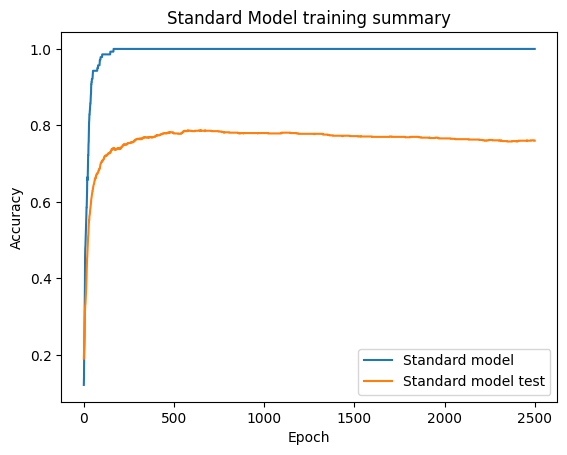

Training spanning tree model...
0 2.1392149925231934 0.1 0.164


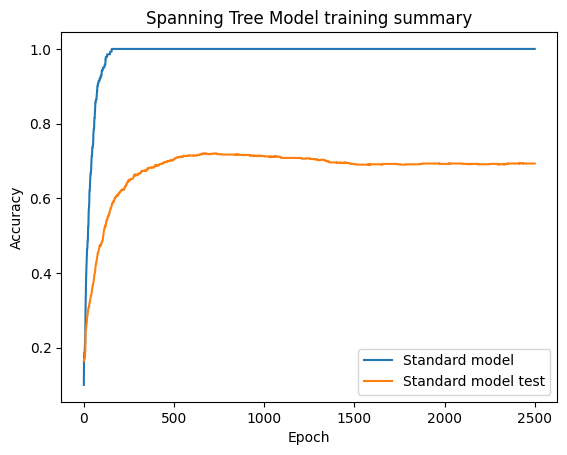

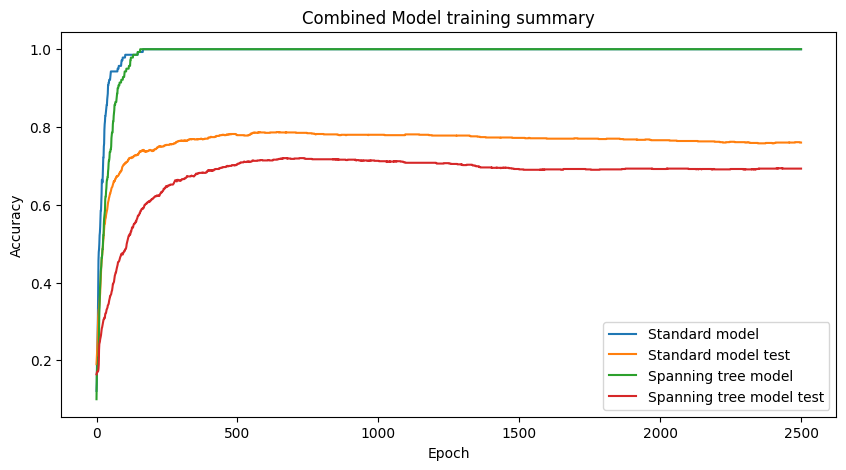

3dnarrow
Training standard model...
0 3.2656147480010986 0.15 0.197


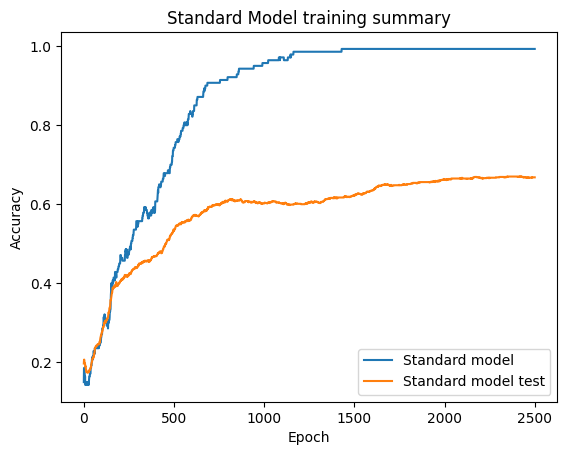

Training spanning tree model...
0 4.9284892082214355 0.14285714285714285 0.064


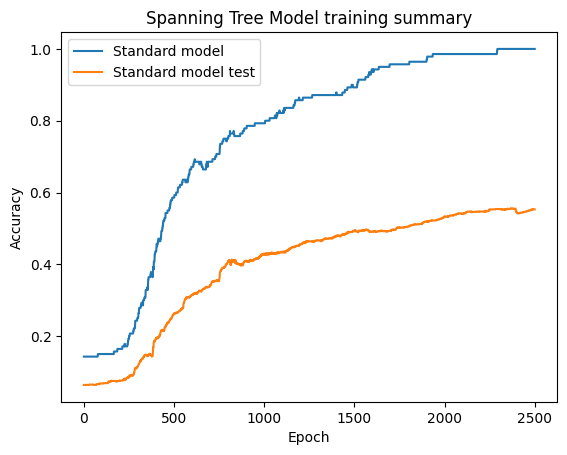

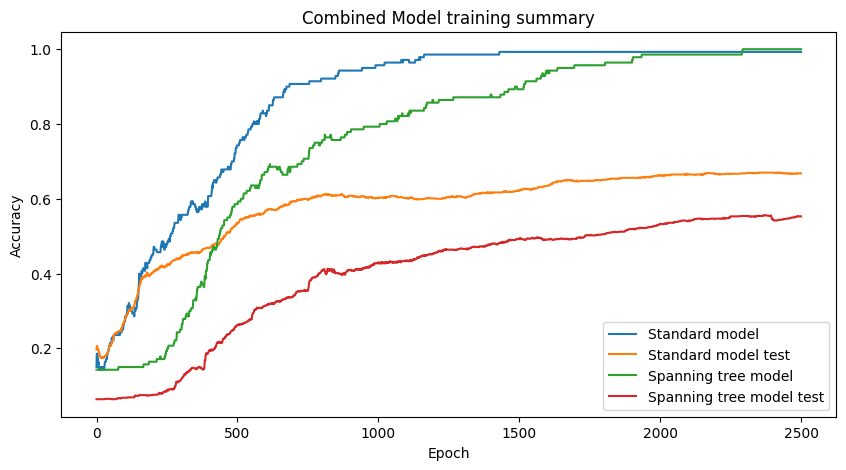

3dwide
Training standard model...
0 7.665359020233154 0.17857142857142858 0.134


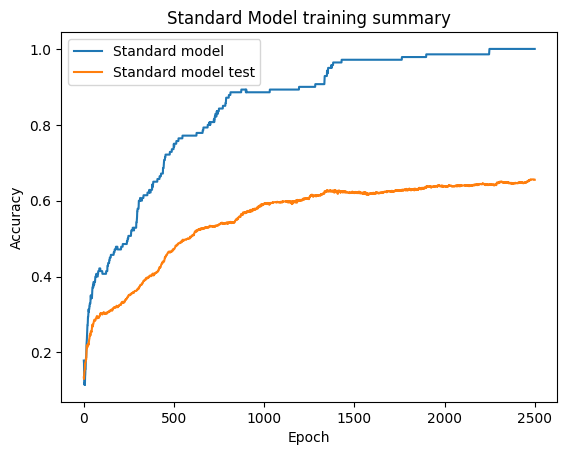

Training spanning tree model...
0 2.7505431175231934 0.15 0.145


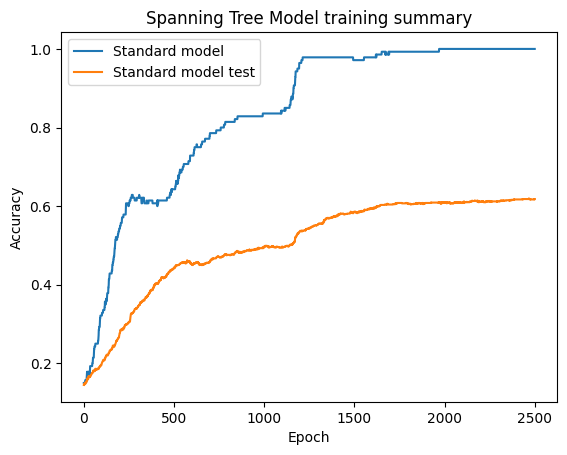

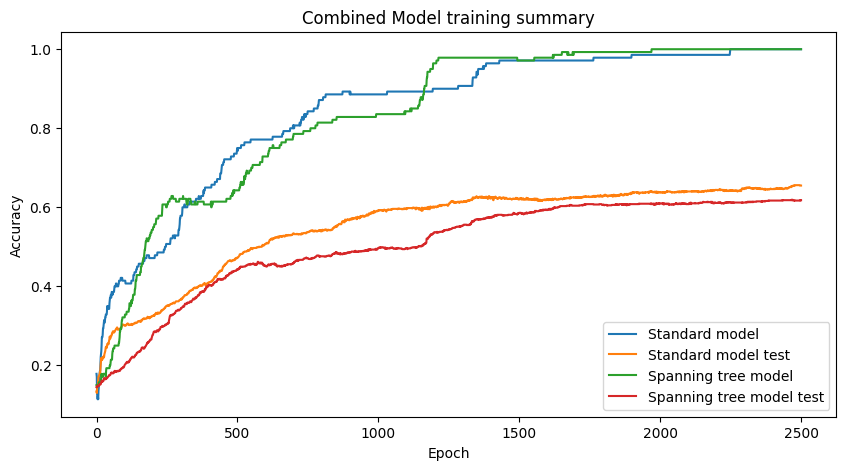

2d
Training standard model...
0 3.1394762992858887 0.08571428571428572 0.139


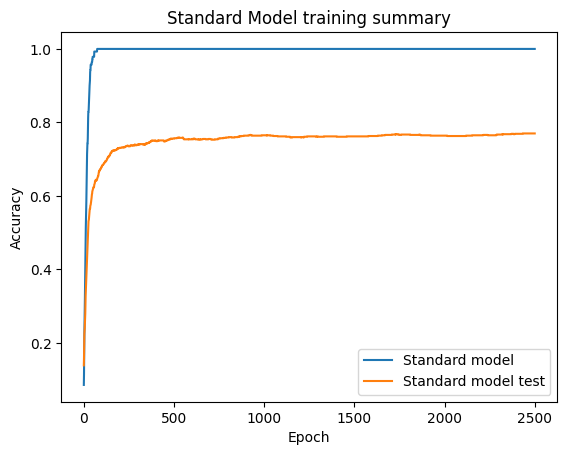

Training spanning tree model...
0 2.7270710468292236 0.12857142857142856 0.116


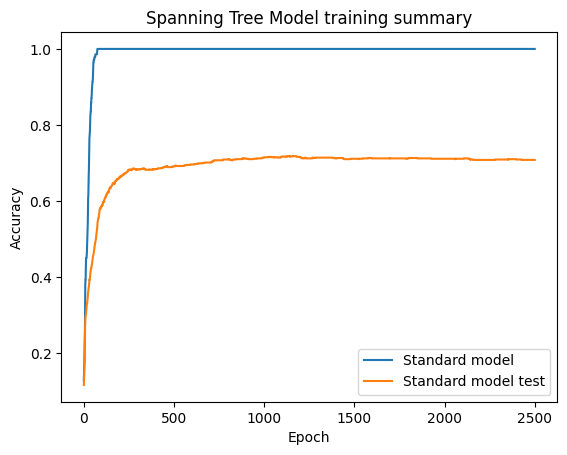

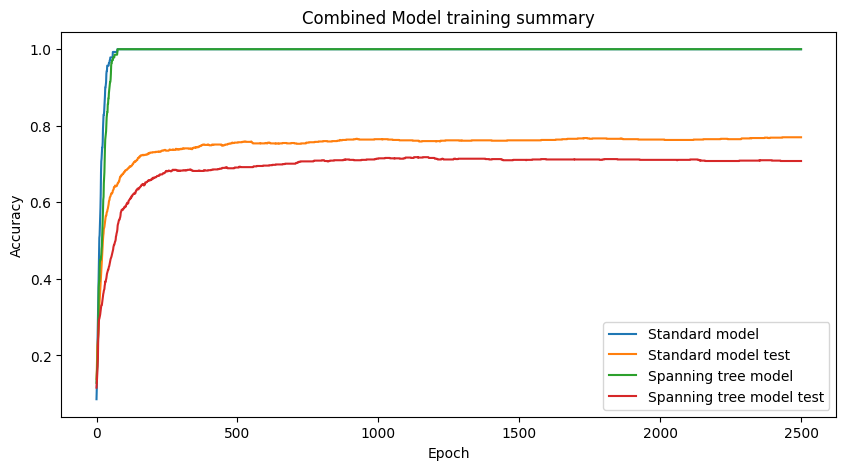

3dnarrow
Training standard model...
0 7.2265143394470215 0.05714285714285714 0.039


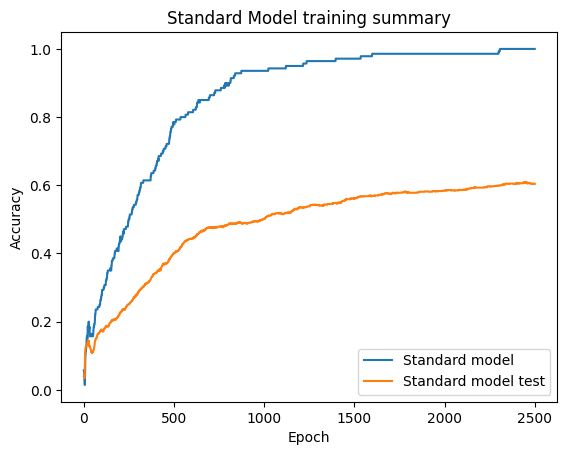

Training spanning tree model...
0 2.0406007766723633 0.12857142857142856 0.161


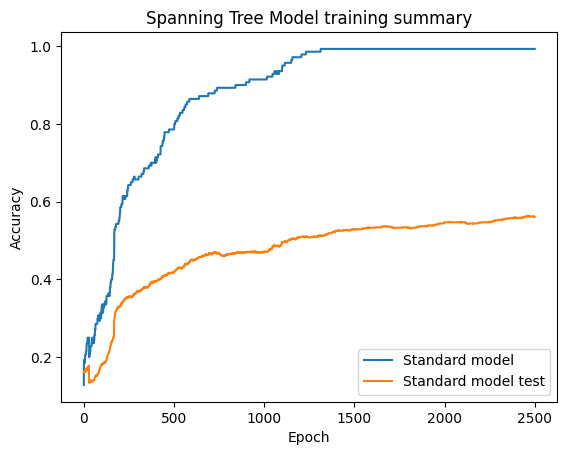

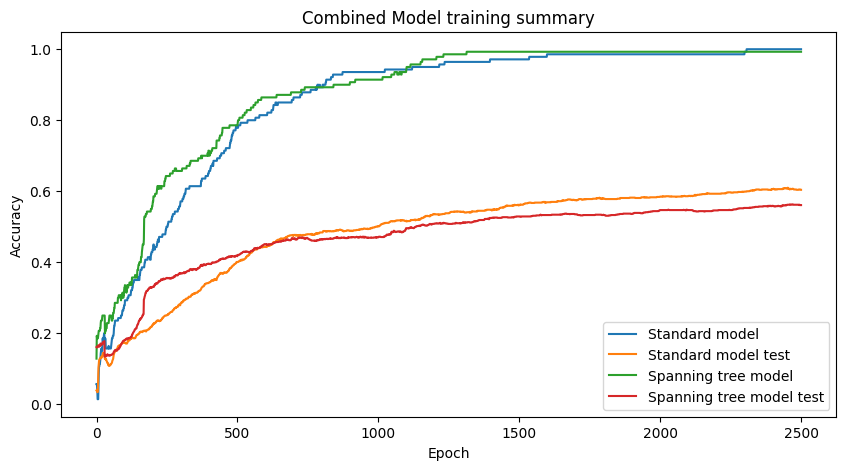

3dwide
Training standard model...
0 4.0516357421875 0.15 0.152


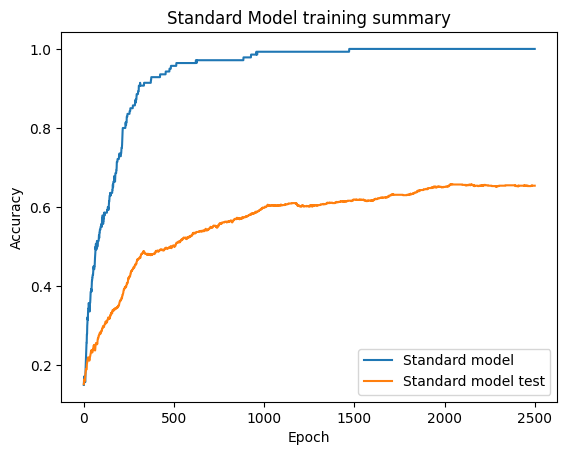

Training spanning tree model...
0 3.3868942260742188 0.19285714285714287 0.127


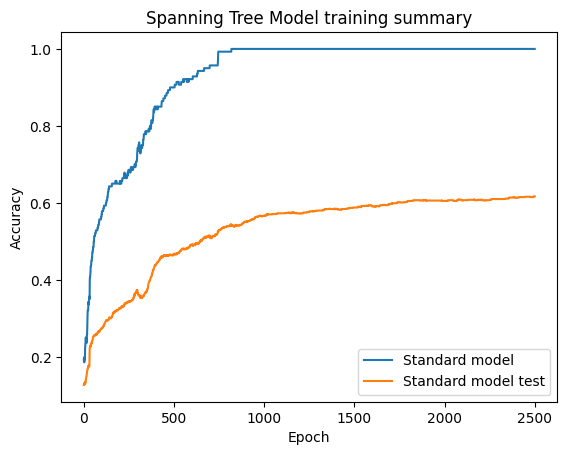

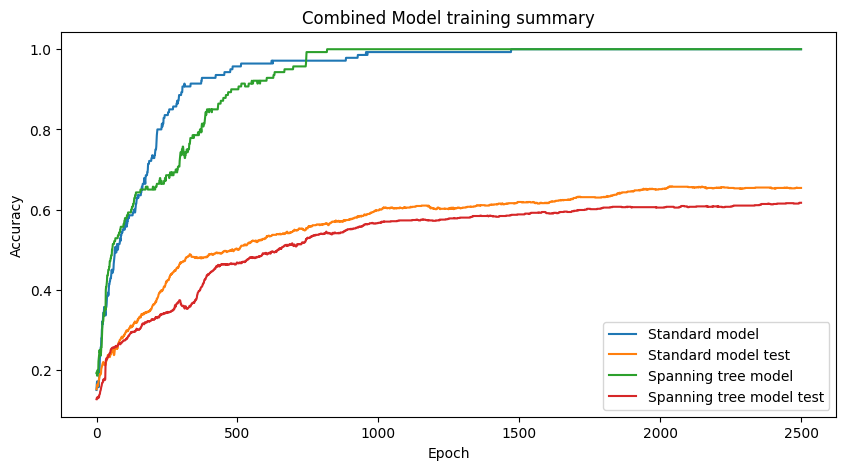

2d
Training standard model...
0 4.097651958465576 0.14285714285714285 0.136


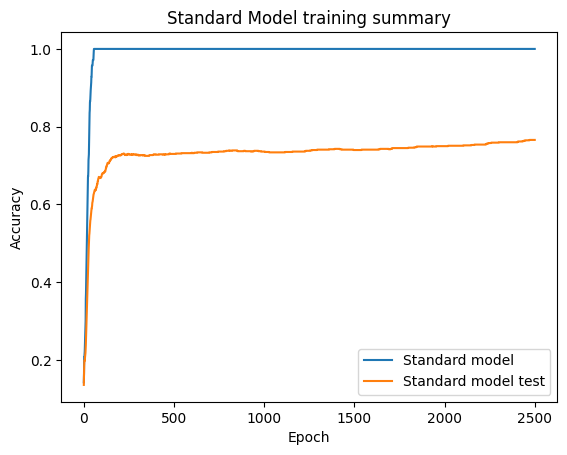

Training spanning tree model...
0 2.4573655128479004 0.15714285714285714 0.081


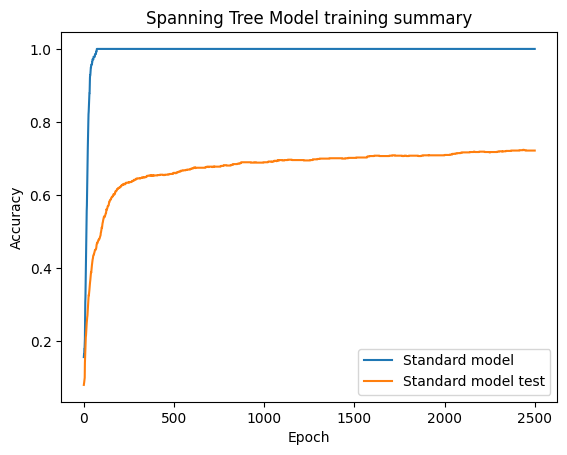

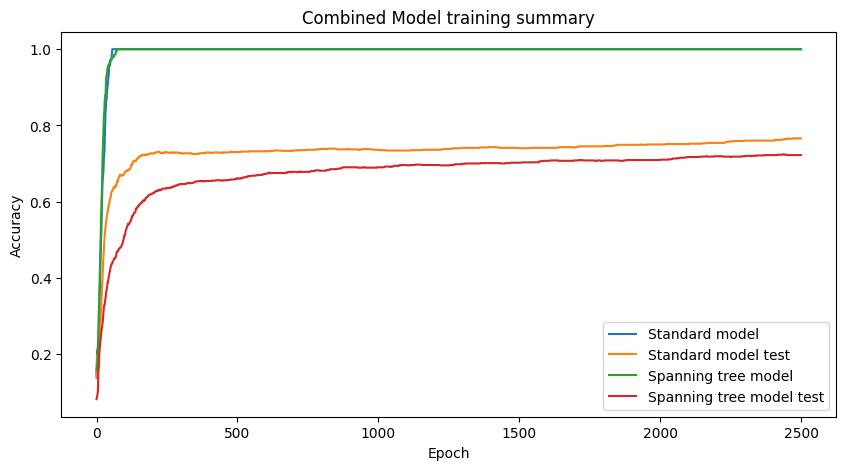

3dnarrow
Training standard model...
0 5.796789646148682 0.18571428571428572 0.105


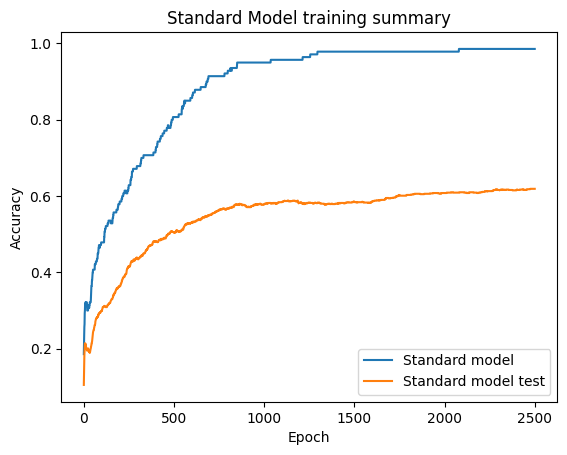

Training spanning tree model...
0 2.0915884971618652 0.1357142857142857 0.152


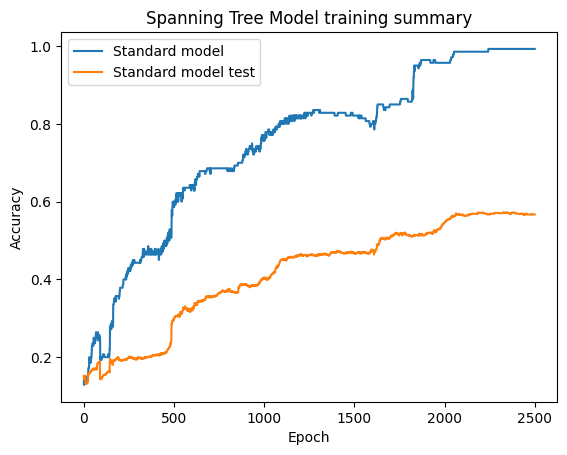

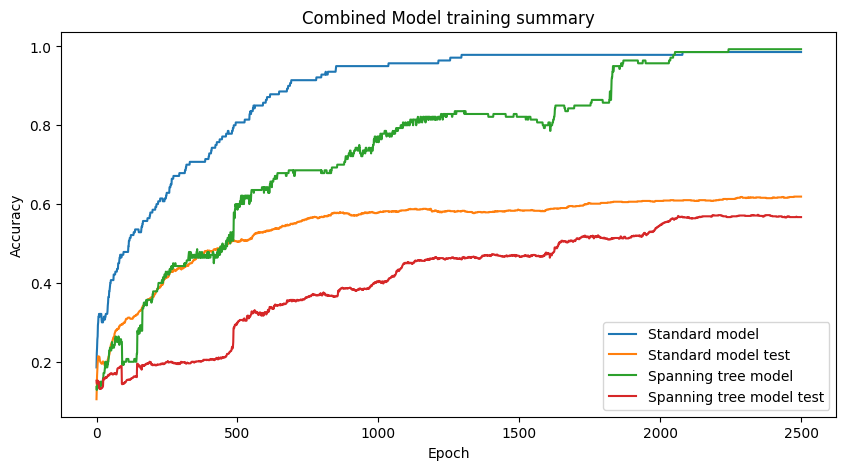

3dwide
Training standard model...
0 7.685640335083008 0.30714285714285716 0.205


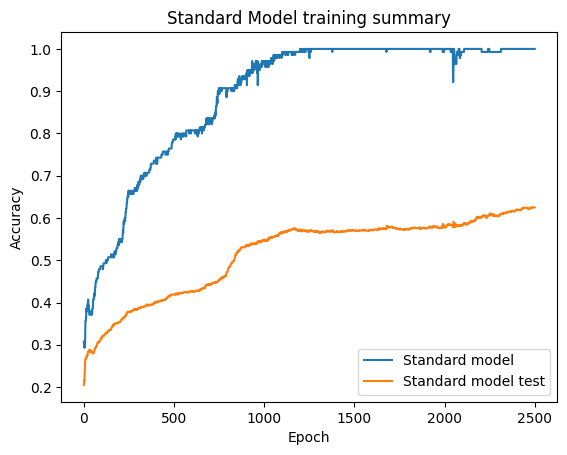

Training spanning tree model...
0 2.7934489250183105 0.07142857142857142 0.067


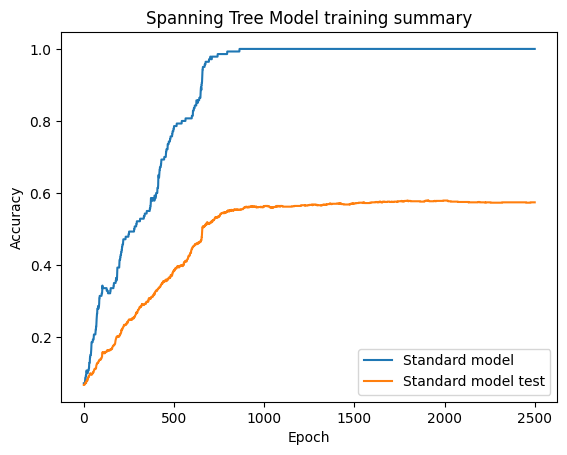

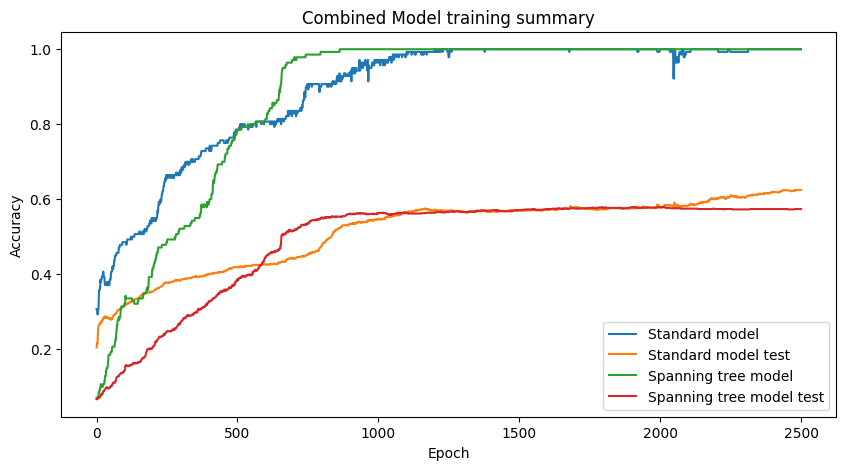

In [ ]:
cora_loss_fn = nn.CrossEntropyLoss()

weightDecays = [0.1, 0.01, 0.001]

for decay in weightDecays:
  cora_params = {
    "learning_rate": 1e-4,
    "num_epochs": 2500,
    "weight_decay": decay
  }

  print("2d")
  cora2DManager.trainModels(params=cora_params, loss_fn=cora_loss_fn, print_rate=100000)
  print("3dnarrow")
  cora3DNarrowManager.trainModels(params=cora_params, loss_fn=cora_loss_fn, print_rate=100000)
  print("3dwide")
  cora3DWideManager.trainModels(params=cora_params, loss_fn=cora_loss_fn, print_rate=100000)

# coraResultsHighWeightDecay = cora2DManager.trainModels(params = cora_params, loss_fn = cora_loss_fn, print_rate=100000)

In [ ]:
dataset_cora.num_node_features, dataset_cora.num_classes

(1433, 7)

In [ ]:
dataset_citeseer.num_node_features, dataset_citeseer.num_classes

(3703, 6)

In [34]:
citeseer2dManager = ModelManager(
  data=data_citeseer,
  save_file_stem='/content/gdrive/My Drive/params/citeseer',
  model_params={
    "input_dim": dataset_citeseer.num_node_features,
    "gnn_hidden_dim": 128,
    "gnn_output_dim": 128,
    "mlp_hidden_dim": 128,
    "mlp_output_dim": dataset_citeseer.num_classes,
    "gnn_num_layers": 2,
    "mlp_num_layers": 2,
})

citeseer3dNarrowManager = ModelManager(
  data=data_citeseer,
  save_file_stem='/content/gdrive/My Drive/params/citeseer',
  model_params={
    "input_dim": dataset_citeseer.num_node_features,
    "gnn_hidden_dim": 10,
    "gnn_output_dim": 10,
    "mlp_hidden_dim": 10,
    "mlp_output_dim": dataset_citeseer.num_classes,
    "gnn_num_layers": 3,
    "mlp_num_layers": 2,
})

citeseer3dWideManager = ModelManager(
  data=data_citeseer,
  save_file_stem='/content/gdrive/My Drive/params/citeseer',
  model_params={
    "input_dim": dataset_citeseer.num_node_features,
    "gnn_hidden_dim": 20,
    "gnn_output_dim": 20,
    "mlp_hidden_dim": 20,
    "mlp_output_dim": dataset_citeseer.num_classes,
    "gnn_num_layers": 3,
    "mlp_num_layers": 2,
})

citseer1dManager = ModelManager(
  data=data_citeseer,
  save_file_stem='/content/gdrive/My Drive/params/citeseer',
  model_params={
    "input_dim": dataset_citeseer.num_node_features,
    "gnn_hidden_dim": 30,
    "gnn_output_dim": 30,
    "mlp_hidden_dim": 30,
    "mlp_output_dim": dataset_citeseer.num_classes,
    "gnn_num_layers": 1,
    "mlp_num_layers": 2,
})

0.1
2d
Training standard model...
0 2.1205790042877197 0.16666666666666666 0.204


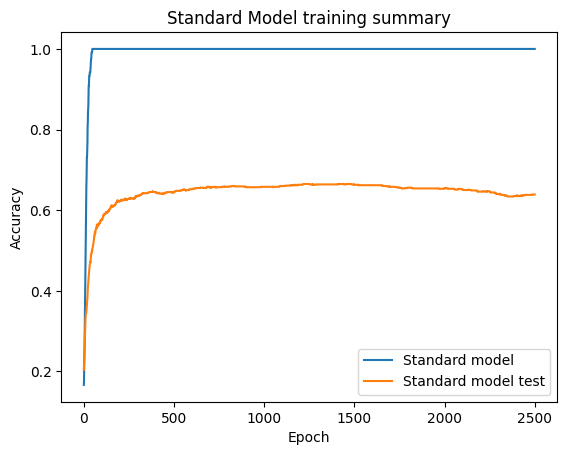

Training spanning tree model...
0 1.8584421873092651 0.11666666666666667 0.189


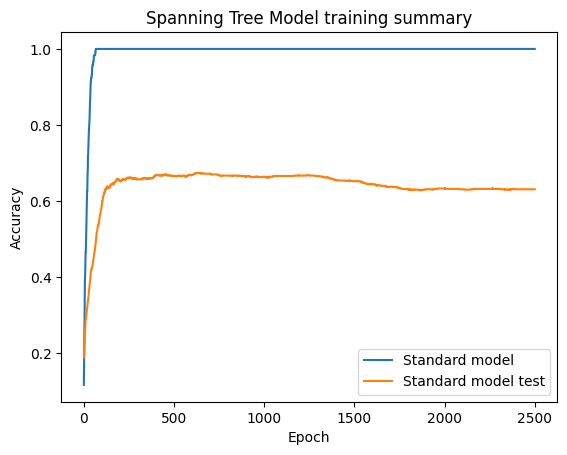

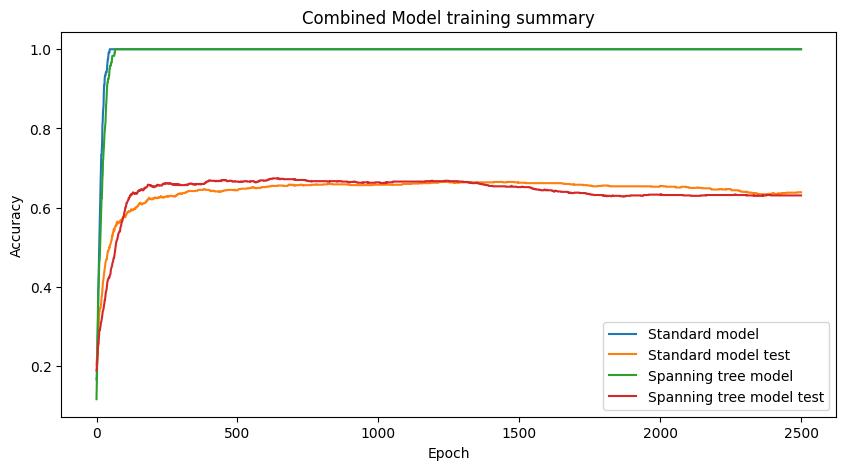

3dnarrow
Training standard model...
0 1.8357142210006714 0.18333333333333332 0.263


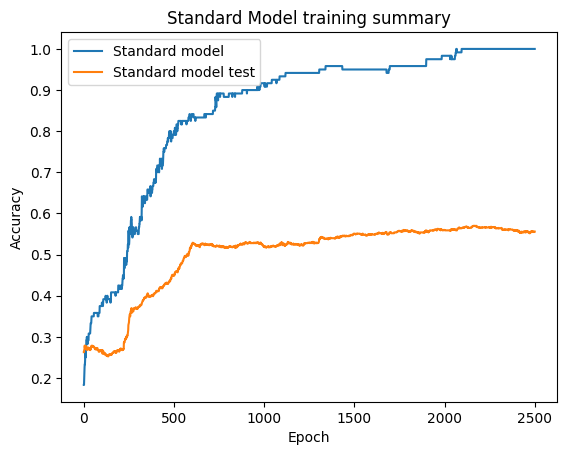

Training spanning tree model...
0 1.9355567693710327 0.15 0.175


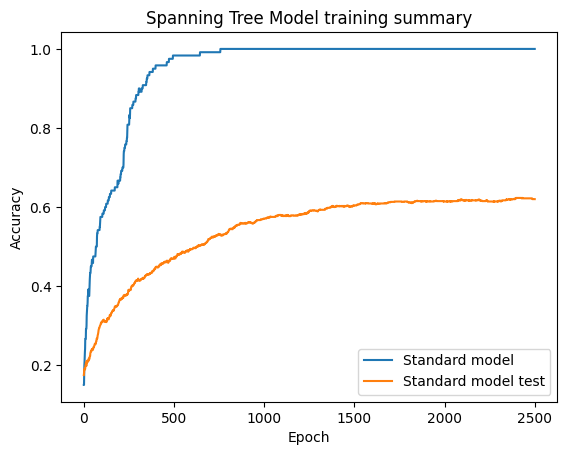

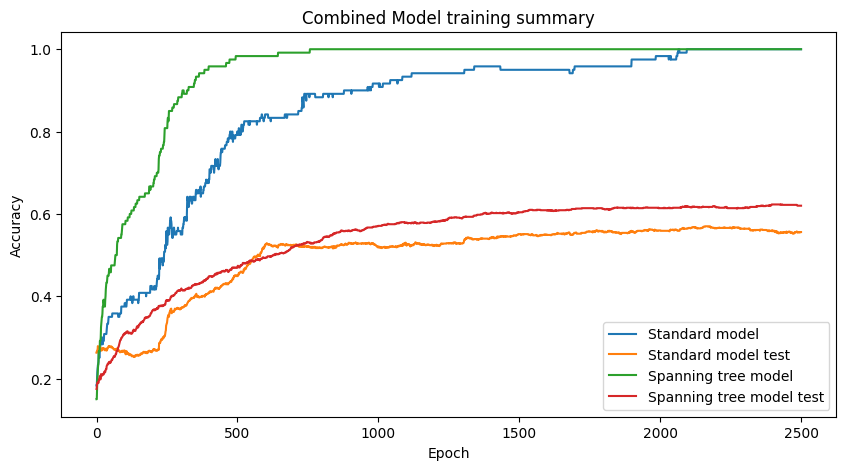

3dwide
Training standard model...
0 3.509190797805786 0.19166666666666668 0.212


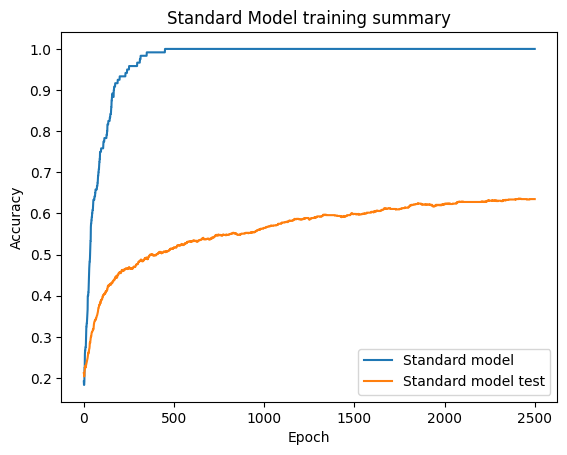

Training spanning tree model...
0 2.008680820465088 0.13333333333333333 0.123


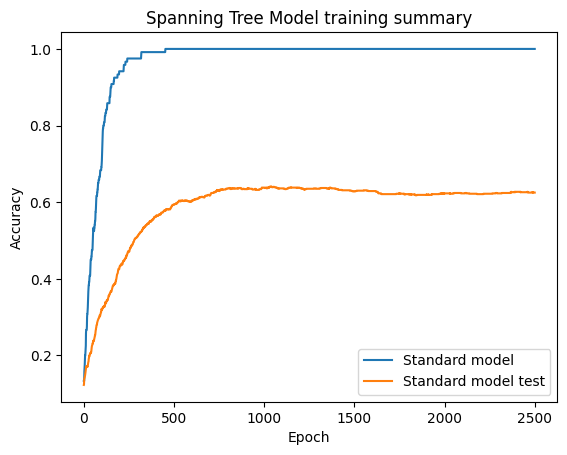

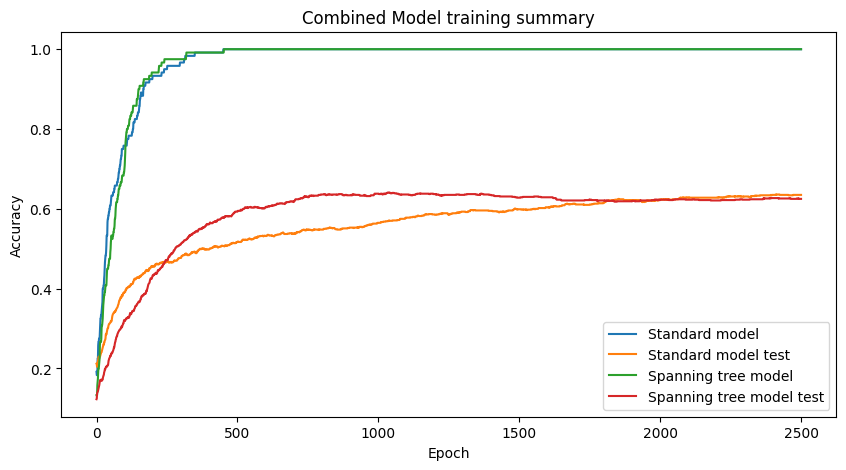

0.01
2d
Training standard model...
0 2.4223520755767822 0.21666666666666667 0.232


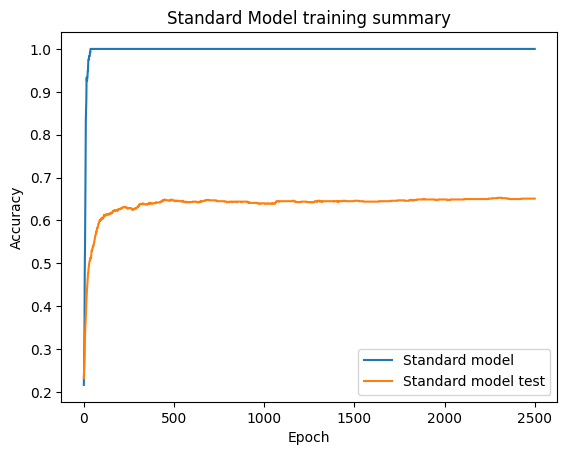

Training spanning tree model...
0 1.7762402296066284 0.21666666666666667 0.217


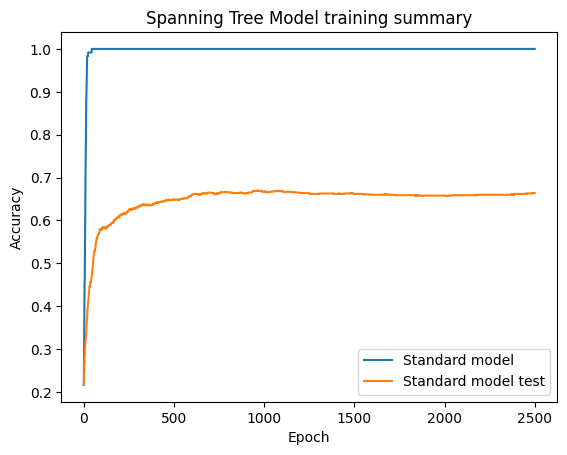

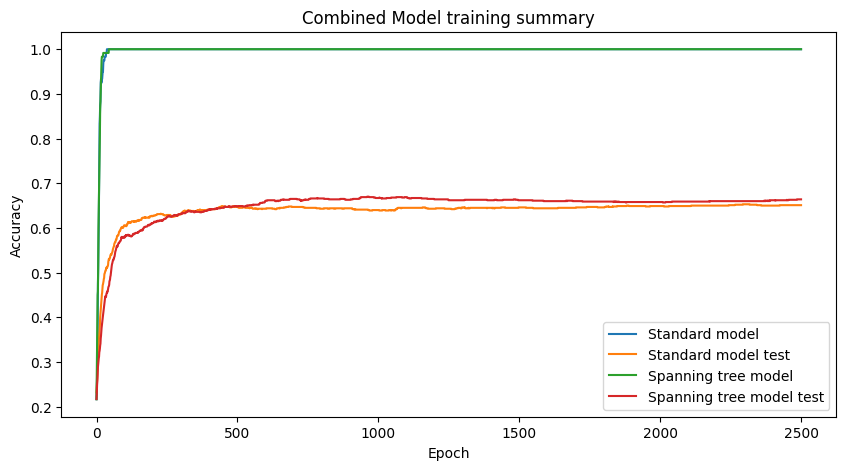

3dnarrow
Training standard model...
0 2.405431032180786 0.13333333333333333 0.187


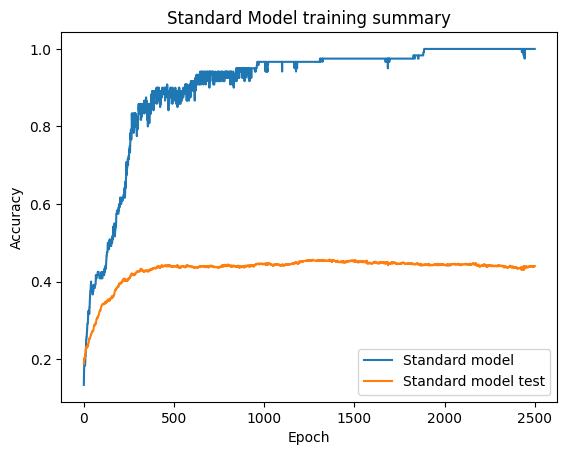

Training spanning tree model...
0 2.3556745052337646 0.175 0.16


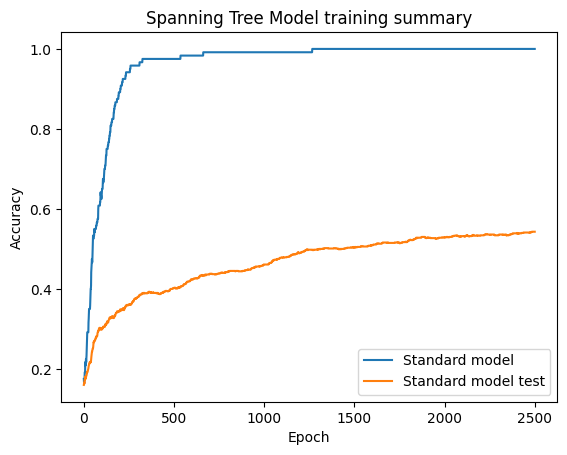

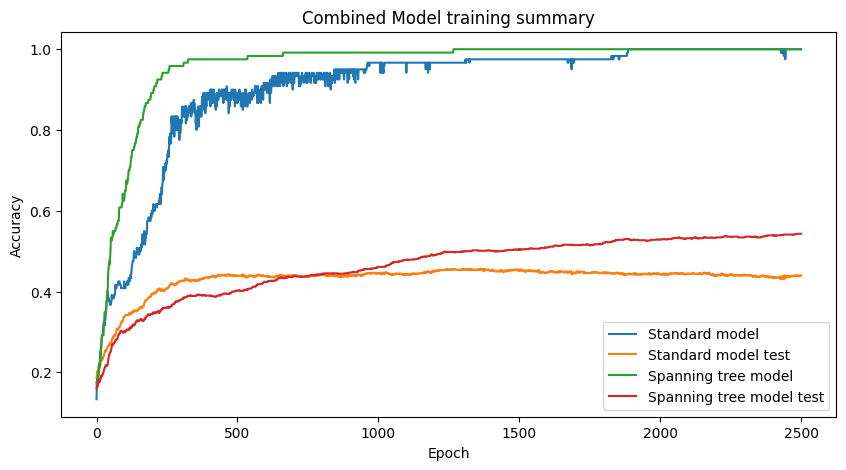

3dwide
Training standard model...
0 2.7995316982269287 0.11666666666666667 0.134


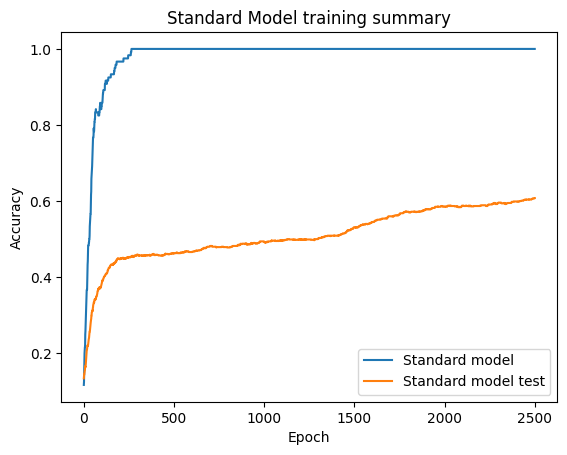

Training spanning tree model...
0 1.8921349048614502 0.13333333333333333 0.194


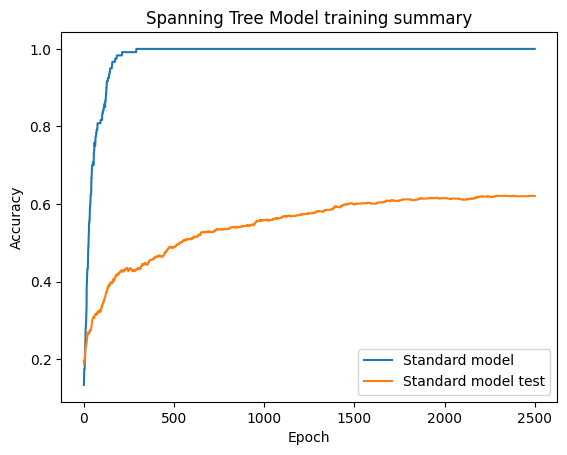

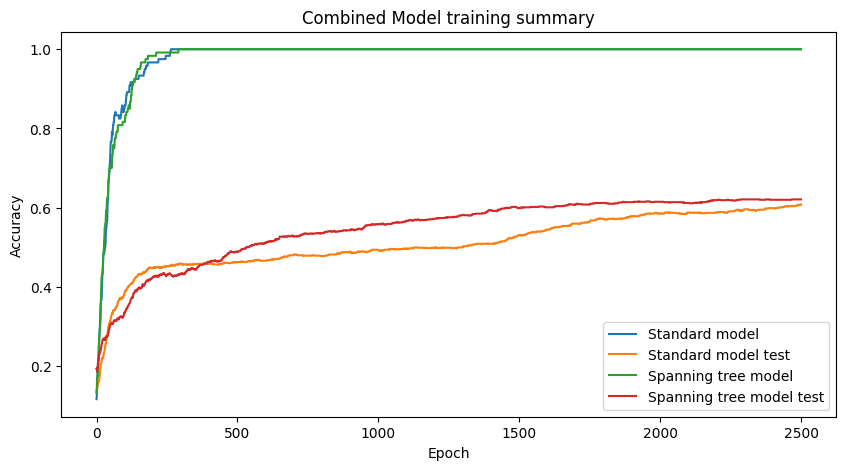

0.001
2d
Training standard model...
0 3.236794948577881 0.15 0.155


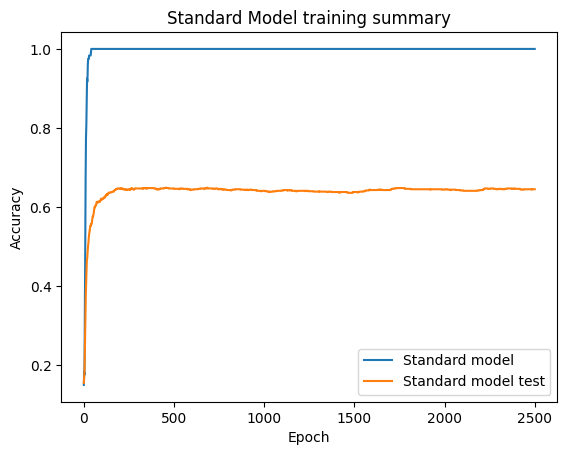

Training spanning tree model...
0 1.8542149066925049 0.15833333333333333 0.184


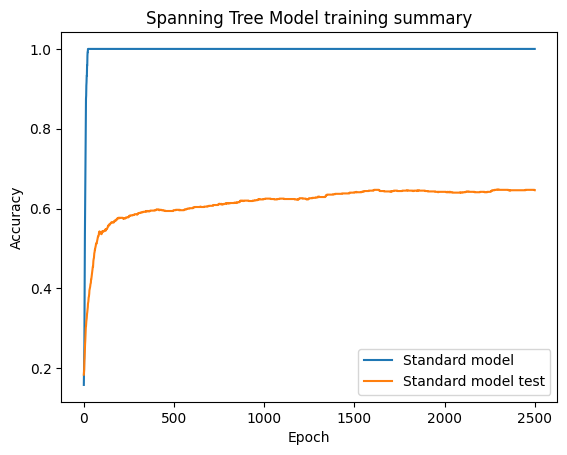

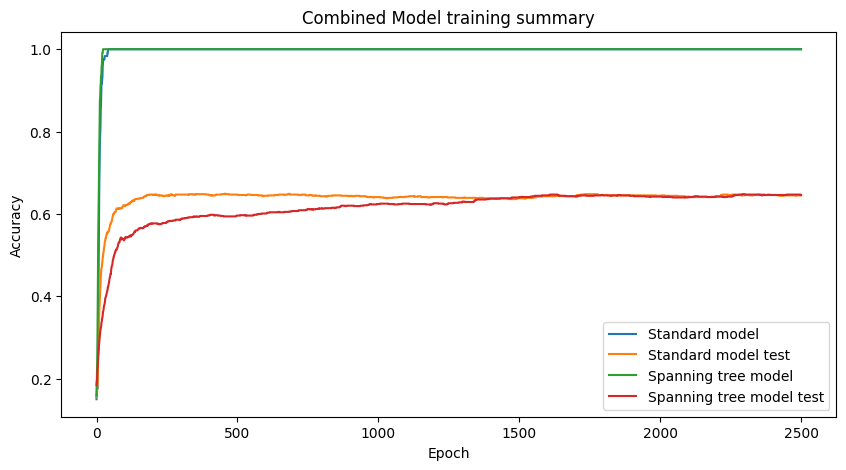

3dnarrow
Training standard model...
0 3.7407004833221436 0.16666666666666666 0.182


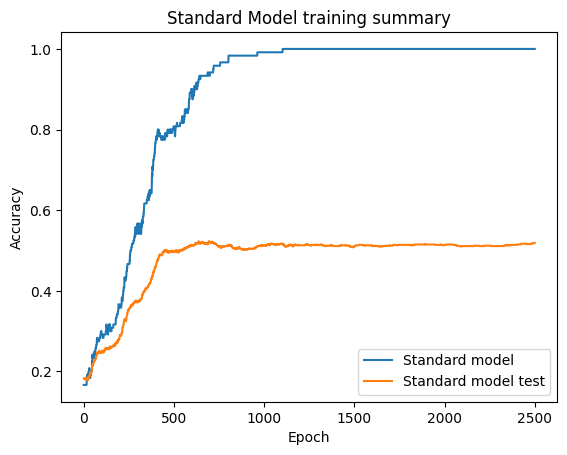

Training spanning tree model...
0 1.7920210361480713 0.13333333333333333 0.079


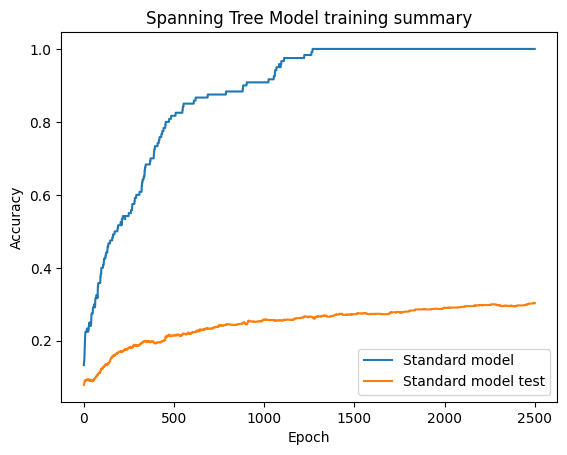

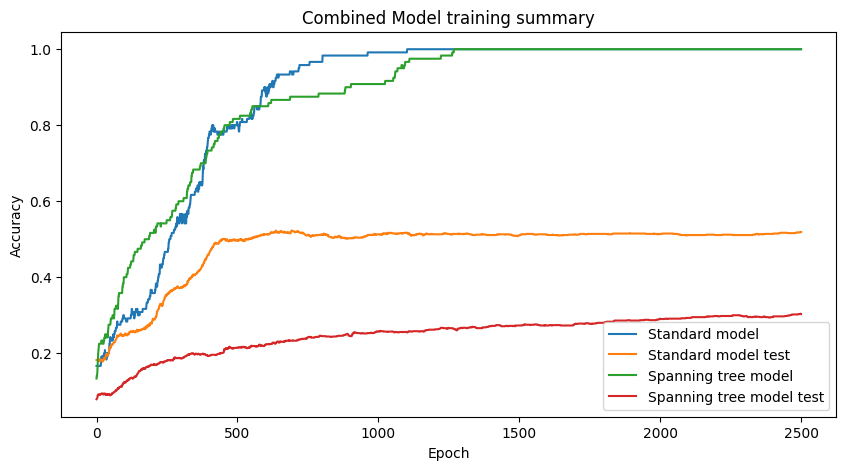

3dwide
Training standard model...
0 4.034091949462891 0.175 0.192


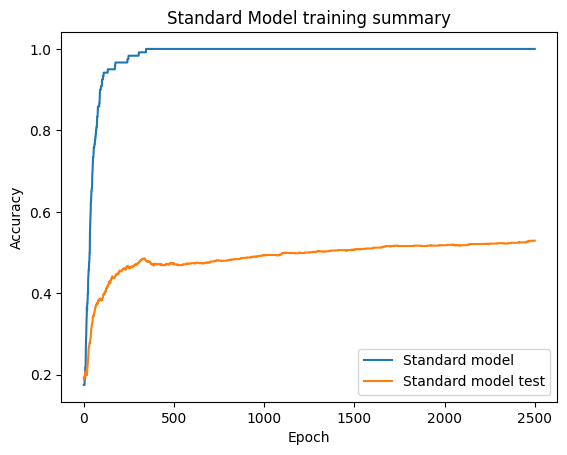

Training spanning tree model...
0 1.8038519620895386 0.125 0.187


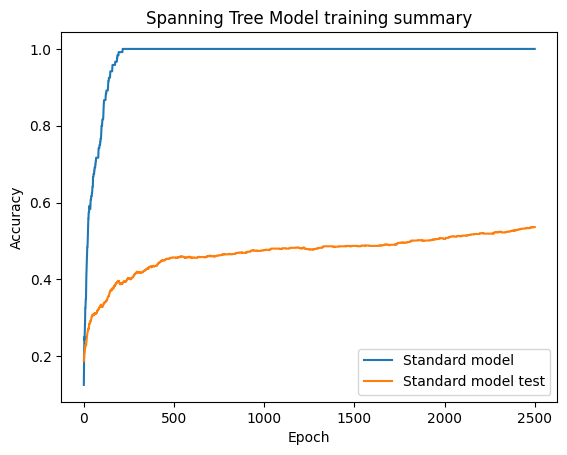

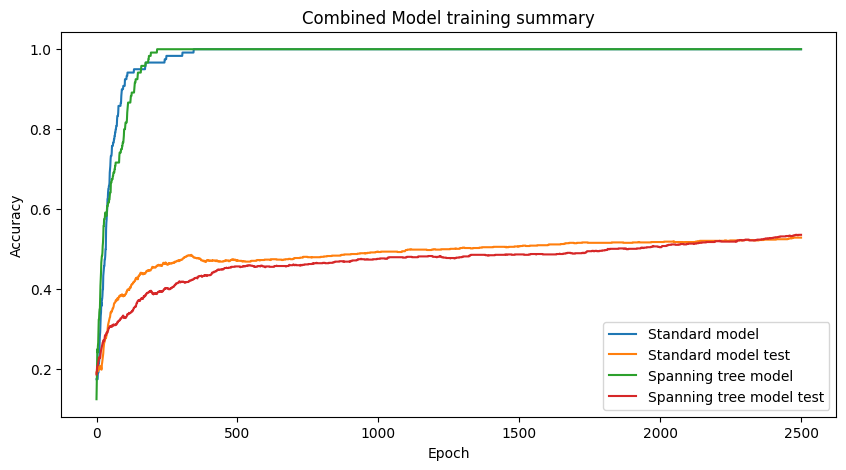

In [ ]:
cora_loss_fn = nn.CrossEntropyLoss()

weightDecays = [0.1, 0.01, 0.001]

for decay in weightDecays:
  cora_params = {
    "learning_rate": 1e-4,
    "num_epochs": 2500,
    "weight_decay": decay
  }

  print(decay)

  print("2d")
  citeseer2dManager.trainModels(params=cora_params, loss_fn=cora_loss_fn, print_rate=100000)
  print("3dnarrow")
  citeseer3dNarrowManager.trainModels(params=cora_params, loss_fn=cora_loss_fn, print_rate=100000)
  print("3dwide")
  citeseer3dWideManager.trainModels(params=cora_params, loss_fn=cora_loss_fn, print_rate=100000)

Training standard model...
0 14.937952041625977 0.14285714285714285 0.069


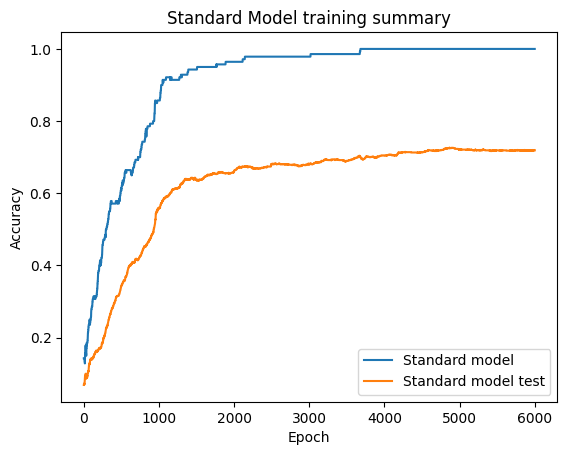

Training spanning tree model...
0 3.008666515350342 0.07857142857142857 0.126


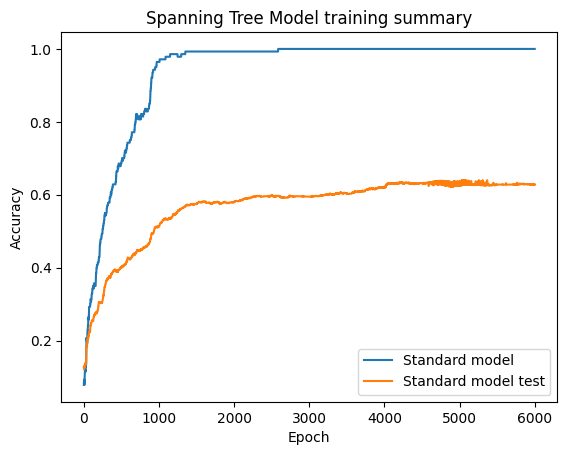

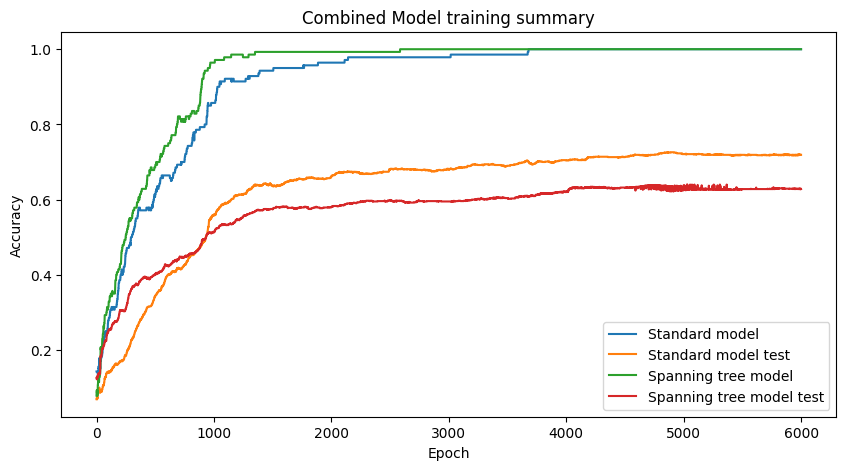

(([14.937952041625977,
   13.978349685668945,
   13.024005889892578,
   12.077910423278809,
   11.146641731262207,
   10.238175392150879,
   9.367100715637207,
   8.547965049743652,
   7.794510364532471,
   7.068790912628174,
   6.363260746002197,
   5.706170558929443,
   5.166324138641357,
   4.667669296264648,
   4.256264686584473,
   3.9737305641174316,
   3.751321315765381,
   3.581368923187256,
   3.4348552227020264,
   3.336704969406128,
   3.2642102241516113,
   3.1990745067596436,
   3.1426522731781006,
   3.0986218452453613,
   3.0559897422790527,
   3.0194592475891113,
   2.9864797592163086,
   2.953354835510254,
   2.9166715145111084,
   2.8755099773406982,
   2.8336637020111084,
   2.7917568683624268,
   2.7526135444641113,
   2.714956760406494,
   2.679137706756592,
   2.6453793048858643,
   2.6109509468078613,
   2.577559471130371,
   2.5446691513061523,
   2.5109286308288574,
   2.478484630584717,
   2.44669771194458,
   2.4160969257354736,
   2.385721206665039,
   2.357

In [ ]:
# Some interesting reults to run again for longer
results = cora3DNarrowManager.trainModels(
  params = {
    "learning_rate": 1e-4,
    "num_epochs": 6000,
    "weight_decay": 0.1
  }, print_rate = 1000000
)

Training standard model...
0 3.348618745803833 0.17142857142857143 0.311


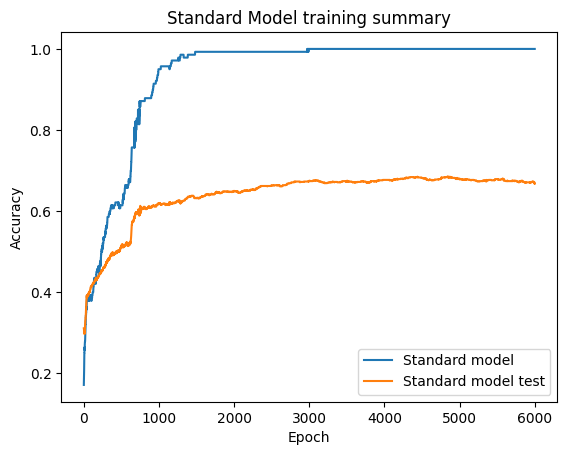

Training spanning tree model...
0 2.4247541427612305 0.15 0.083


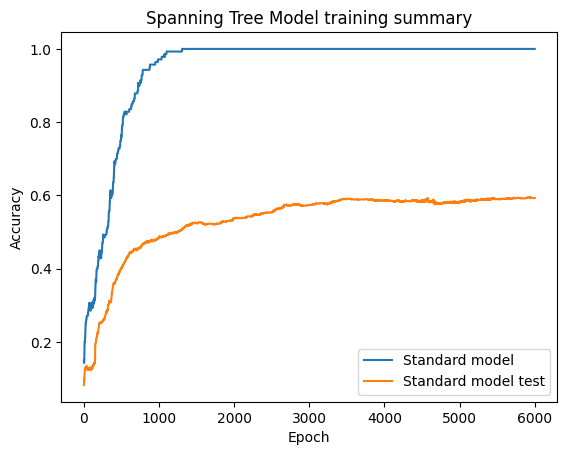

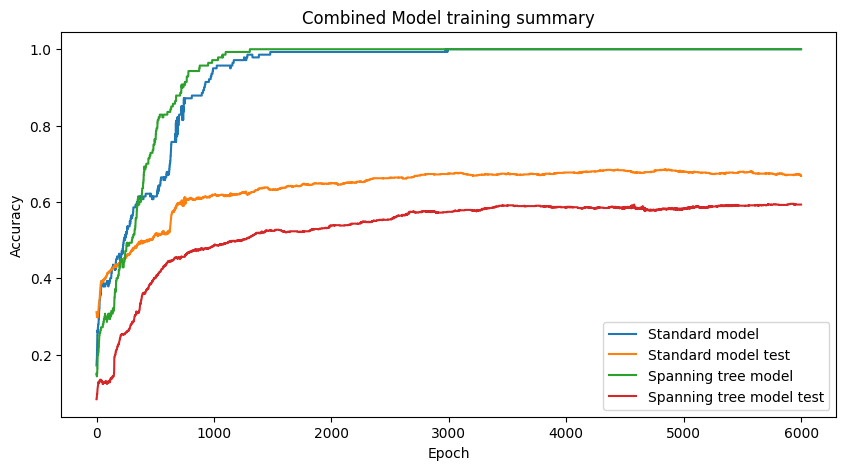

(([3.348618745803833,
   3.148860216140747,
   2.9804415702819824,
   2.8321876525878906,
   2.730994939804077,
   2.6435909271240234,
   2.554076671600342,
   2.4645397663116455,
   2.382061719894409,
   2.3065361976623535,
   2.2354493141174316,
   2.1737213134765625,
   2.1236186027526855,
   2.0803565979003906,
   2.0434887409210205,
   2.0129575729370117,
   1.9827427864074707,
   1.9543319940567017,
   1.9306306838989258,
   1.9111688137054443,
   1.8940839767456055,
   1.877662181854248,
   1.8619022369384766,
   1.8463600873947144,
   1.8323264122009277,
   1.819330096244812,
   1.807161569595337,
   1.795640230178833,
   1.7850786447525024,
   1.775076150894165,
   1.7656593322753906,
   1.756798505783081,
   1.7483031749725342,
   1.740015983581543,
   1.7320598363876343,
   1.7239933013916016,
   1.715778112411499,
   1.7077686786651611,
   1.69992995262146,
   1.692352533340454,
   1.6850019693374634,
   1.6786943674087524,
   1.6727811098098755,
   1.667244553565979,
   1.

In [ ]:
results2 = cora3DNarrowManager.trainModels(
  params = {
    "learning_rate": 1e-4,
    "num_epochs": 6000,
    "weight_decay": 0.01
  }, print_rate = 1000000
)

Training standard model...
0 6.8513288497924805 0.125 0.132


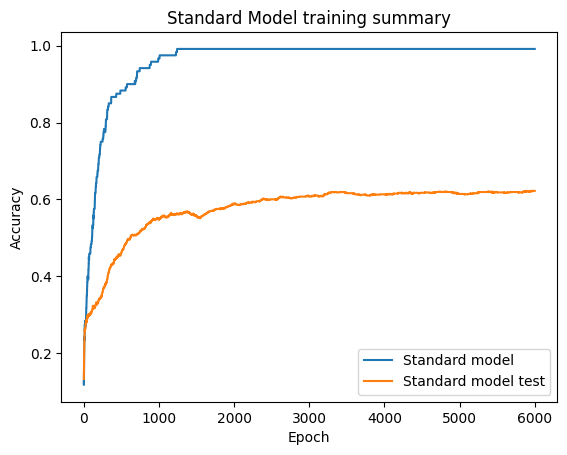

Training spanning tree model...
0 1.835252046585083 0.14166666666666666 0.181


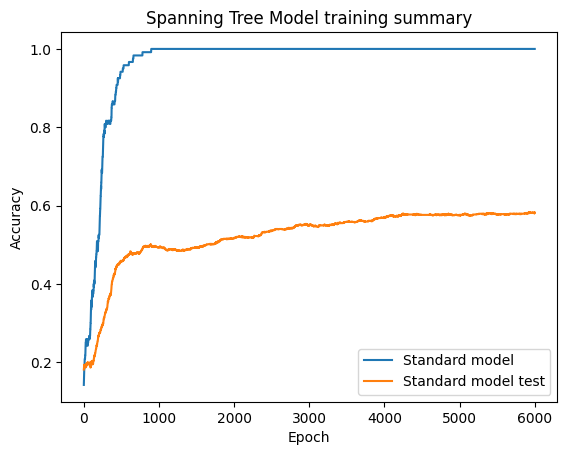

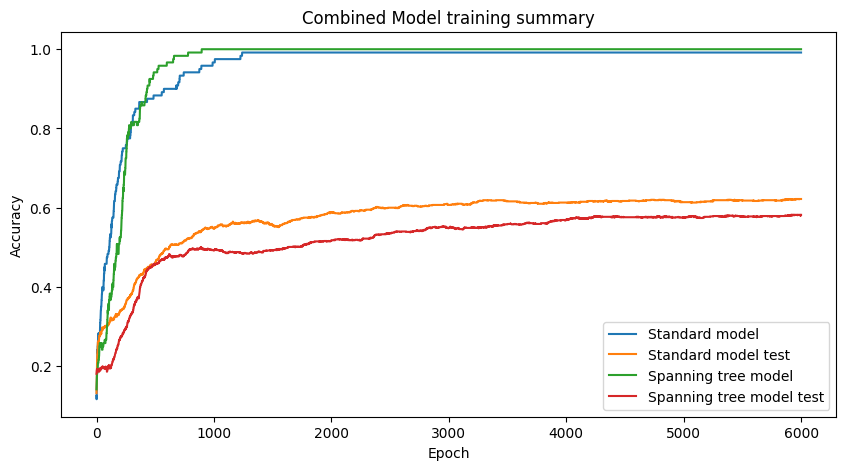

In [ ]:
r3 = citeseer3dNarrowManager.trainModels(
  params = {
    "learning_rate": 1e-4,
    "num_epochs": 6000,
    "weight_decay": 0.1
  }, print_rate = 1000000
)

Training standard model...
0 6.254838943481445 0.15833333333333333 0.119


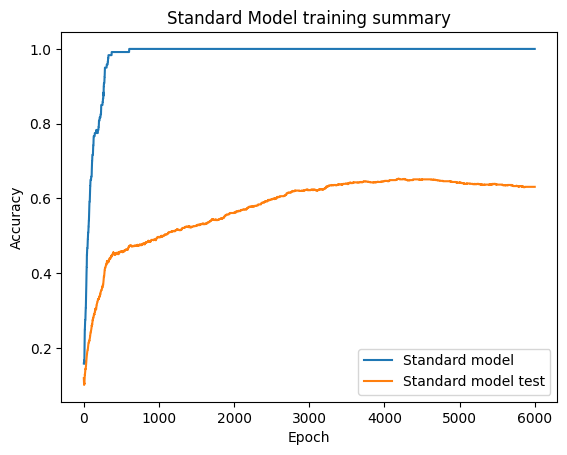

Training spanning tree model...
0 1.7433134317398071 0.275 0.212


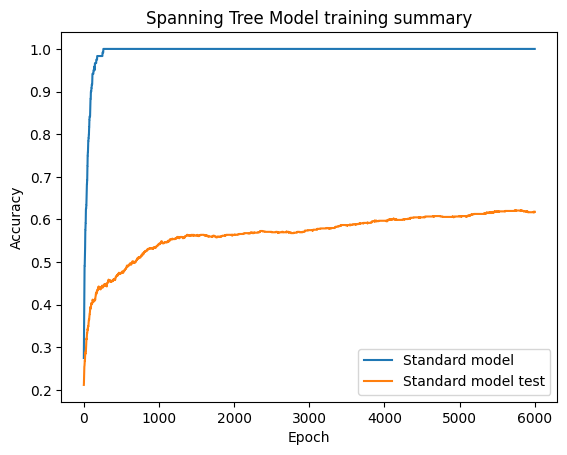

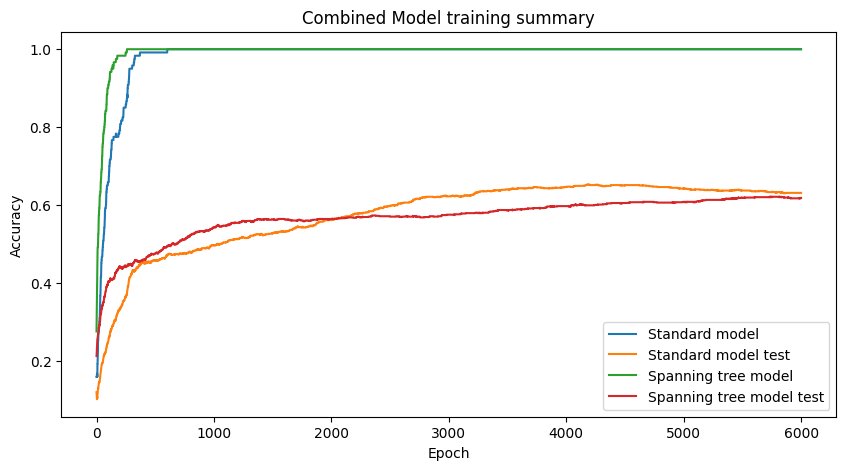

In [ ]:
r4 = citeseer3dWideManager.trainModels(
  params = {
    "learning_rate": 1e-4,
    "num_epochs": 6000,
    "weight_decay": 0.01
  }, print_rate = 1000000
)

Training standard model...
0 10.483522415161133 0.16666666666666666 0.16


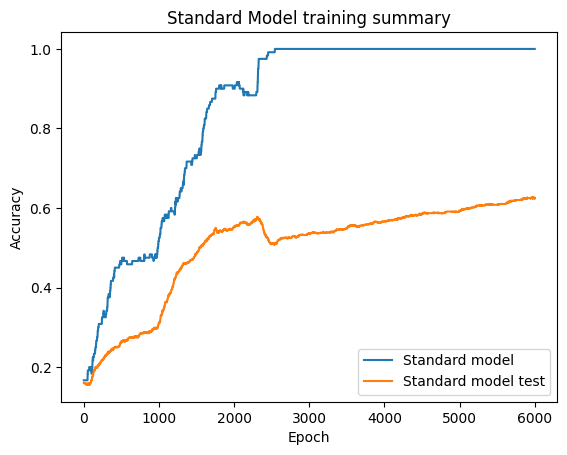

Training spanning tree model...
0 2.1656270027160645 0.19166666666666668 0.126


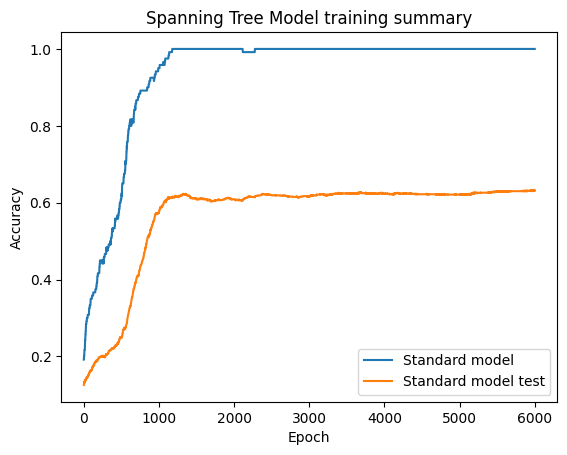

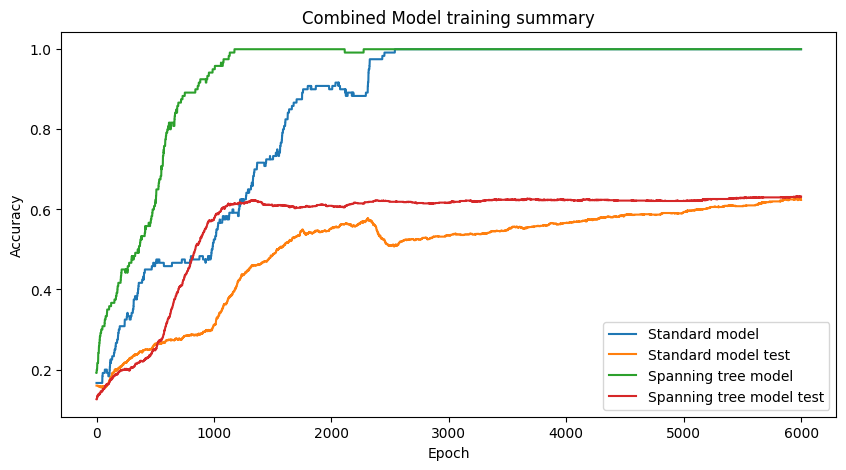

In [ ]:
r5 = citeseer3dNarrowManager.trainModels(
  params = {
    "learning_rate": 1e-4,
    "num_epochs": 6000,
    "weight_decay": 0.1
  }, print_rate = 1000000
)

In [ ]:
# small test to see the kinds of objects we need to be making
r5 = citeseer3dNarrowManager.trainModels(
  params = {
    "learning_rate": 1e-4,
    "num_epochs": 6000,
    "weight_decay": 0.1
  }, print_rate = 1000000
)

In [18]:
class GraphDataset:
  def __init__(self, num_nodes=1000, num_features=1, num_neighbors=20):
    self.num_nodes = num_nodes
    self.num_features = num_features
    self.num_neighbors = num_neighbors
    self.adj_matrix = self.create_adjacency_matrix()
    self.x = self.generate_node_features()
    self.y = self.generate_node_labels()
    self.train_mask = self.create_train_mask()
    self.test_mask = self.create_test_mask()

  def create_adjacency_matrix(self):
    matrix = torch.zeros(self.num_nodes, self.num_nodes, dtype=torch.float32)

    for i in range(self.num_nodes):
      for j in range(-self.num_neighbors, self.num_neighbors + 1):
        if j != 0:
          neighbor_idx = (i + j) % self.num_nodes
          matrix[i, neighbor_idx] = 1.0

    return matrix.to(device)

  def generate_node_features(self):
    return torch.normal(mean=0.0, std=0.09, size=(self.num_nodes, self.num_features), dtype=torch.float32).to(device)

  def generate_node_labels(self):
    labels = []
    total0s = 0
    total1s = 0
    total2s = 0

    for i in range(self.num_nodes):
      neighbor_indices = [(i + j) % self.num_nodes for j in range(-self.num_neighbors, self.num_neighbors + 1)]
      neighbor_features_sum = torch.sum(self.x[neighbor_indices], dim=0)
      total_sum = torch.sum(self.x[i]) + torch.sum(neighbor_features_sum)

      if total_sum < -1:
        labels.append(0)
        total0s += 1
      elif -1 <= total_sum <= 1:
        labels.append(1)
        total1s += 1
      else:
        labels.append(2)
        total2s += 1

    print(total0s, total1s, total2s)

    return torch.tensor(labels, dtype=torch.long).to(device)

  def create_train_mask(self):
    train_mask = torch.zeros(self.num_nodes, dtype=torch.bool)
    train_mask[int(0.8 * self.num_nodes):] = True
    return train_mask.to(device)

  def create_test_mask(self):
    test_mask = torch.zeros(self.num_nodes, dtype=torch.bool)
    test_mask[:int(0.8 * self.num_nodes)] = True
    return test_mask.to(device)


In [37]:
class SyntheticModelManager(ModelManager):
  def __init__(self, model_params, data, save_file_stem):
    super().__init__(model_params, data, save_file_stem)

  def data_to_adj_matrix_pair(self, data):
    adj_matrix = data.adj_matrix
    spanning_trees = self.bfs_spanning_trees(adj_matrix)

    assert(torch.all(adj_matrix * spanning_trees == spanning_trees).item())

    return adj_matrix, spanning_trees


In [20]:
syntheticManager = SyntheticModelManager(
  data=GraphDataset(
      num_nodes = 10000,
      num_features = 10,
  ),
  save_file_stem='/content/gdrive/My Drive/params/synthetic',
  model_params={
    "input_dim": 10,
    "gnn_hidden_dim": 128,
    "gnn_output_dim": 128,
    "mlp_hidden_dim": 128,
    "mlp_output_dim": 3,
    "gnn_num_layers": 2,
    "mlp_num_layers": 2,
})

3182 4090 2728


Training standard model...
0 1.8522658348083496 0.318 0.364125
100 0.45290106534957886 0.817 0.626125
200 0.38162434101104736 0.8485 0.651125
300 0.3488064110279083 0.862 0.654875
400 0.32654058933258057 0.868 0.655875
500 0.3084111213684082 0.871 0.652875
600 0.29253140091896057 0.878 0.64975
700 0.27779385447502136 0.884 0.6445
800 0.2641218304634094 0.89 0.64525
900 0.2503609359264374 0.8955 0.645125
1000 0.235805481672287 0.9055 0.6455
1100 0.2199445217847824 0.9155 0.647125
1200 0.20232269167900085 0.9215 0.6485
1300 0.18272055685520172 0.9375 0.6515
1400 0.161564439535141 0.947 0.656
1500 0.14018778502941132 0.9575 0.66325
1600 0.12020387500524521 0.965 0.669625
1700 0.10204640030860901 0.9755 0.671125
1800 0.08366186916828156 0.9855 0.674875
1900 0.07059957832098007 0.9915 0.677375
2000 0.0595354288816452 0.994 0.6795
2100 0.051323533058166504 0.9965 0.683375
2200 0.04524970427155495 0.9975 0.68875
2300 0.03984825313091278 0.998 0.69175
2400 0.035784464329481125 0.998 0.694
2500

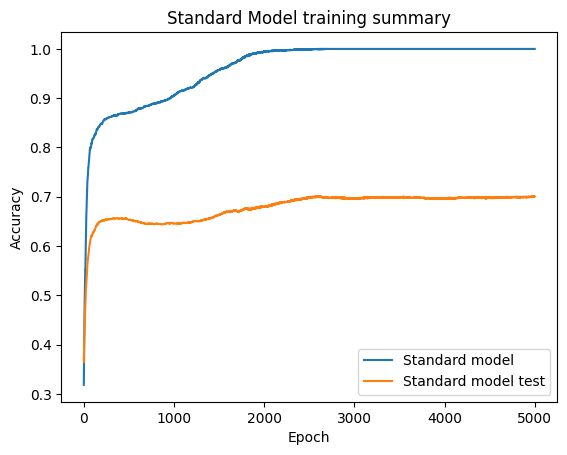

Training spanning tree model...
0 1.088639497756958 0.377 0.337
100 0.8953772187232971 0.6545 0.43575
200 0.7158184051513672 0.7205 0.456625
300 0.6008955836296082 0.746 0.467375
400 0.514692485332489 0.778 0.461
500 0.45780885219573975 0.792 0.457625
600 0.42136088013648987 0.808 0.457125
700 0.3952600657939911 0.819 0.45425
800 0.37254735827445984 0.83 0.452
900 0.35043641924858093 0.8435 0.449625
1000 0.32679128646850586 0.8615 0.447125
1100 0.3015791177749634 0.877 0.444
1200 0.2751435935497284 0.8925 0.439625
1300 0.24793556332588196 0.9125 0.438375
1400 0.22009319067001343 0.925 0.435375
1500 0.19245637953281403 0.947 0.43525
1600 0.16553325951099396 0.963 0.43
1700 0.1405043601989746 0.9775 0.42775
1800 0.11840113252401352 0.985 0.425625
1900 0.09982085227966309 0.992 0.425625
2000 0.08511020243167877 0.9975 0.426375
2100 0.07357466220855713 0.999 0.42675
2200 0.06468112021684647 0.9995 0.42825
2300 0.057772260159254074 0.9995 0.426
2400 0.0524836890399456 0.9995 0.425375
2500 0

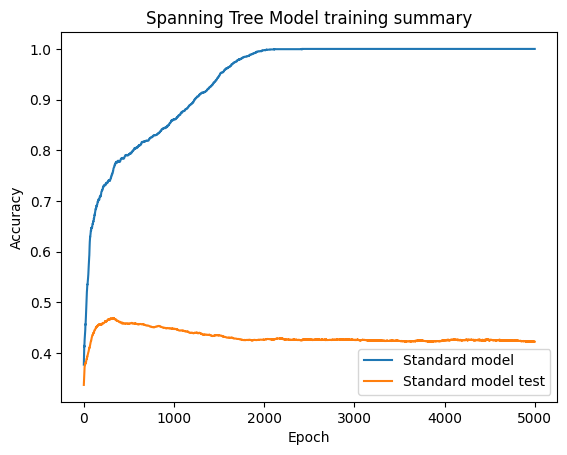

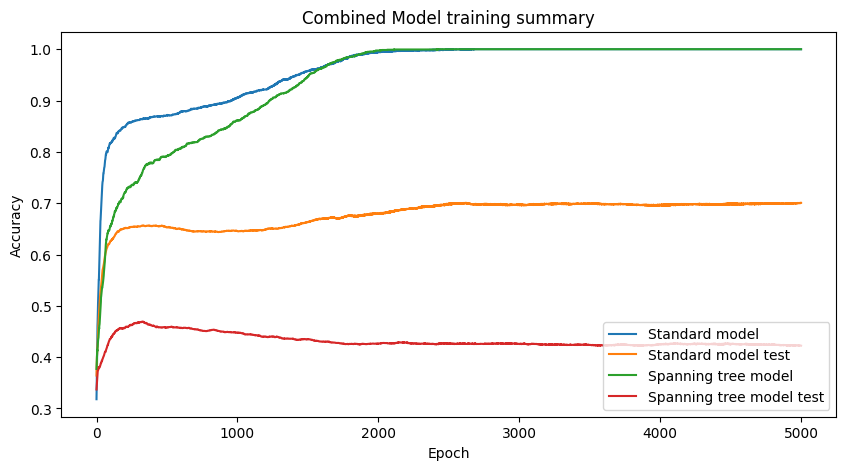

In [ ]:
r6 = syntheticManager.trainModels(
  params = {
    "learning_rate": 1e-4,
    "num_epochs": 5000,
    "weight_decay": 0.001
  }, print_rate = 100
)

In [ ]:
syntheticManager = SyntheticModelManager(
  data=GraphDataset(
      num_nodes = 10000,
      num_features = 10,
  ),
  save_file_stem='/content/gdrive/My Drive/params/synthetic',
  model_params={
    "input_dim": 10,
    "gnn_hidden_dim": 16,
    "gnn_output_dim": 16,
    "mlp_hidden_dim": 16,
    "mlp_output_dim": 3,
    "gnn_num_layers": 2,
    "mlp_num_layers": 2,
})

3312 3865 2823


Training standard model...
0 5.085658550262451 0.389 0.272125
100 1.0375407934188843 0.58 0.47225
200 0.7125311493873596 0.6765 0.55425
300 0.6095325946807861 0.723 0.582875
400 0.5423332452774048 0.7525 0.619625
500 0.49577823281288147 0.783 0.6385
600 0.4670412540435791 0.7935 0.649
700 0.44530612230300903 0.8095 0.6565
800 0.42795076966285706 0.82 0.661125
900 0.41238006949424744 0.831 0.664
1000 0.3985327184200287 0.834 0.669625
1100 0.3858909606933594 0.8395 0.67
1200 0.37422120571136475 0.8415 0.6725
1300 0.36282050609588623 0.8455 0.67325
1400 0.35152381658554077 0.8525 0.672125
1500 0.3403337299823761 0.86 0.671375
1600 0.3296451270580292 0.863 0.66775
1700 0.3187849223613739 0.867 0.667125
1800 0.3078882098197937 0.869 0.66775
1900 0.2969852089881897 0.8755 0.669125
2000 0.2854059934616089 0.8775 0.671375
2100 0.2740896940231323 0.8835 0.673875
2200 0.26323750615119934 0.8875 0.678375
2300 0.2523409426212311 0.8965 0.683125
2400 0.24113965034484863 0.9015 0.686125
2500 0.22962

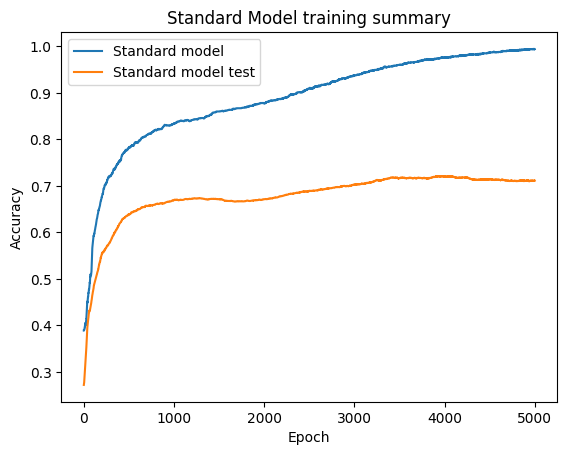

Training spanning tree model...
0 1.1008743047714233 0.3535 0.32425
100 1.0423752069473267 0.5025 0.341125
200 0.9605622291564941 0.5455 0.36475
300 0.8580144047737122 0.6395 0.407625
400 0.7613038420677185 0.6755 0.43725
500 0.6801844239234924 0.715 0.455125
600 0.6194853186607361 0.739 0.458875
700 0.5731890201568604 0.755 0.4595
800 0.5350692868232727 0.7705 0.458125
900 0.5037702322006226 0.7815 0.462
1000 0.478384792804718 0.7895 0.461375
1100 0.45858389139175415 0.7975 0.462375
1200 0.4418480098247528 0.808 0.4615
1300 0.42718544602394104 0.817 0.456875
1400 0.4149206280708313 0.8205 0.453375
1500 0.4038877487182617 0.8225 0.45225
1600 0.3936346173286438 0.822 0.450125
1700 0.38374993205070496 0.825 0.44675
1800 0.3739427924156189 0.834 0.44425
1900 0.36455631256103516 0.837 0.4415
2000 0.3552742302417755 0.8445 0.441125
2100 0.34656822681427 0.8475 0.43875
2200 0.33824172616004944 0.848 0.43725
2300 0.3309027850627899 0.852 0.43775
2400 0.32413628697395325 0.8535 0.4385
2500 0.3

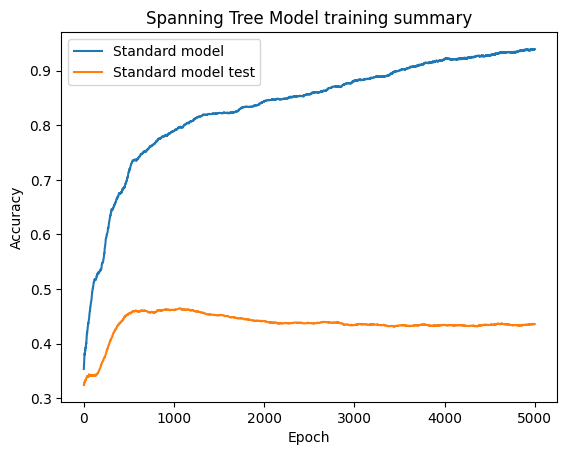

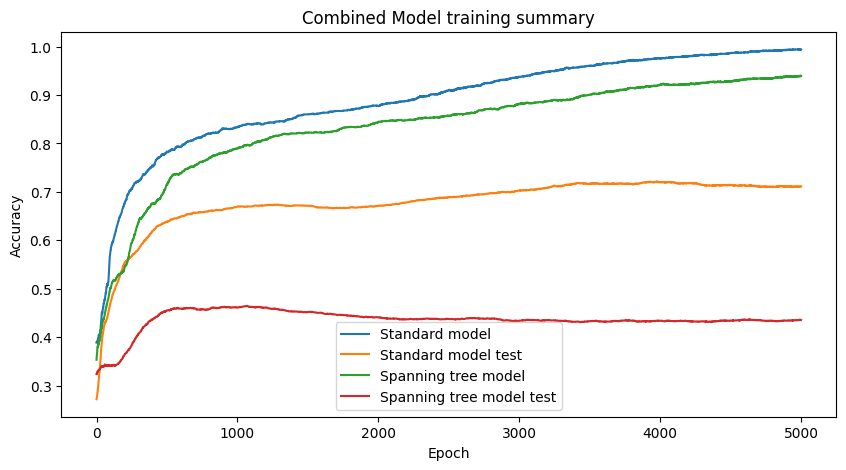

In [ ]:
r7 = syntheticManager.trainModels(
  params = {
    "learning_rate": 3e-4,
    "num_epochs": 5000,
    "weight_decay": 0.001
  }, print_rate = 100
)

In [ ]:
syntheticManager = SyntheticModelManager(
  data=GraphDataset(
      num_nodes = 10000,
      num_features = 10,
  ),
  save_file_stem='/content/gdrive/My Drive/params/synthetic',
  model_params={
    "input_dim": 10,
    "gnn_hidden_dim": 10,
    "gnn_output_dim": 10,
    "mlp_hidden_dim": 10,
    "mlp_output_dim": 3,
    "gnn_num_layers": 1,
    "mlp_num_layers": 2,
})

3376 3947 2677


Training standard model...
0 1.0900462865829468 0.4045 0.340625
100 0.9064667224884033 0.568 0.4535
200 0.6435642838478088 0.7065 0.59775
300 0.4004615247249603 0.881 0.81925
400 0.25934499502182007 0.923 0.883625
500 0.1859562247991562 0.955 0.90725
600 0.1435147225856781 0.9675 0.92275
700 0.11664903908967972 0.975 0.932
800 0.09871690720319748 0.98 0.939
900 0.08553687483072281 0.9835 0.944625
1000 0.07505805790424347 0.986 0.94875
1100 0.06729289144277573 0.9895 0.952375
1200 0.06159725785255432 0.992 0.95525
1300 0.056815020740032196 0.995 0.959
1400 0.052563395351171494 0.9965 0.961
1500 0.048970550298690796 0.9965 0.962375
1600 0.04598962515592575 0.9985 0.9625
1700 0.043408650904893875 0.9985 0.963
1800 0.04108024388551712 0.999 0.964125
1900 0.039069171994924545 0.9995 0.96525
2000 0.03734501823782921 0.9995 0.966125
2100 0.03590773418545723 0.9995 0.967125
2200 0.034696899354457855 0.9995 0.96775
2300 0.033618539571762085 0.9995 0.968375
2400 0.03258509933948517 0.9995 0.9692

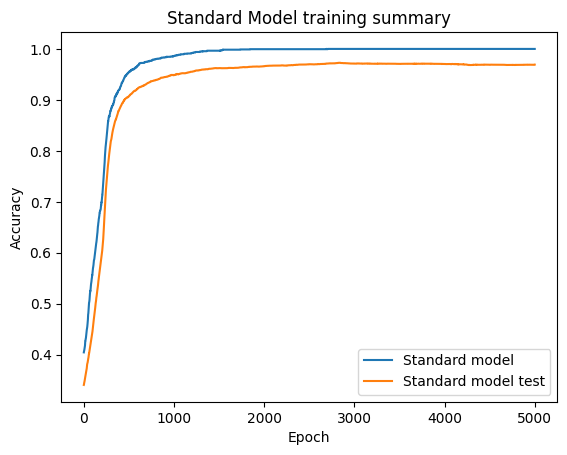

Training spanning tree model...
0 1.0870442390441895 0.385 0.3285
100 1.032355546951294 0.455 0.358875
200 0.994120717048645 0.496 0.383
300 0.9490192532539368 0.5215 0.388375
400 0.8943580985069275 0.5705 0.386625
500 0.8385106325149536 0.6085 0.378375
600 0.7869475483894348 0.6485 0.37375
700 0.7548203468322754 0.6655 0.37625
800 0.7328789830207825 0.678 0.377
900 0.7145913243293762 0.684 0.37775
1000 0.6999741196632385 0.6855 0.376
1100 0.6868363618850708 0.694 0.37525
1200 0.6717674732208252 0.698 0.374625
1300 0.6552303433418274 0.7135 0.374125
1400 0.6397265195846558 0.7245 0.373625
1500 0.6268912553787231 0.73 0.375625
1600 0.6136646270751953 0.7375 0.375125
1700 0.5995489358901978 0.7345 0.3755
1800 0.5881894826889038 0.7445 0.373375
1900 0.5797309279441833 0.7535 0.37075
2000 0.5720663666725159 0.7585 0.368125
2100 0.5656459331512451 0.7585 0.368875
2200 0.5602210164070129 0.7635 0.3675
2300 0.5555048584938049 0.7695 0.367375
2400 0.5505824089050293 0.7675 0.365625
2500 0.5444

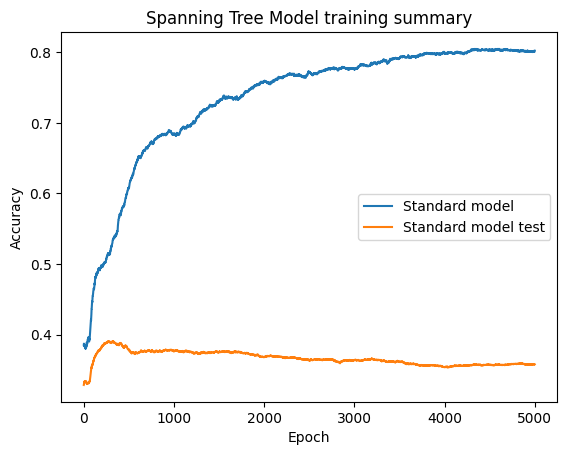

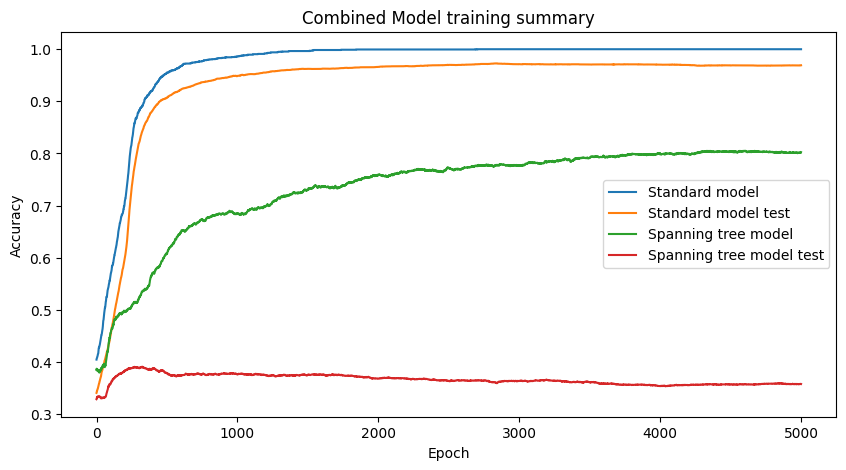

In [ ]:
r8 = syntheticManager.trainModels(
  params = {
    "learning_rate": 1e-3,
    "num_epochs": 5000,
    "weight_decay": 0.001
  }, print_rate = 100
)

In [38]:
syntheticManager = SyntheticModelManager(
  data=GraphDataset(
      num_nodes = 10000,
      num_features = 10,
  ),
  save_file_stem='/content/gdrive/My Drive/params/synthetic',
  model_params={
    "input_dim": 10,
    "gnn_hidden_dim": 10,
    "gnn_output_dim": 10,
    "mlp_hidden_dim": 10,
    "mlp_output_dim": 3,
    "gnn_num_layers": 1,
    "mlp_num_layers": 1,
})

2684 4048 3268


Training standard model...
0 1.097367286682129 0.3375 0.311875
100 0.8778567910194397 0.5935 0.53
200 0.6741787195205688 0.785 0.689
300 0.5174873471260071 0.862 0.77775
400 0.4061548709869385 0.907 0.825125
500 0.32957348227500916 0.922 0.855875
600 0.2756446301937103 0.9345 0.881375
700 0.23678240180015564 0.9465 0.89775
800 0.2087949514389038 0.9515 0.907625
900 0.18746408820152283 0.955 0.91675
1000 0.17000238597393036 0.9635 0.92275
1100 0.15627014636993408 0.965 0.928125
1200 0.14561818540096283 0.9665 0.929375
1300 0.1370719075202942 0.972 0.928625
1400 0.13001319766044617 0.974 0.931125
1500 0.12403704226016998 0.976 0.933125
1600 0.11890487372875214 0.9755 0.936375
1700 0.11450755596160889 0.977 0.93625
1800 0.1107192412018776 0.9775 0.937375
1900 0.10738412290811539 0.9795 0.938
2000 0.10438288003206253 0.98 0.938875
2100 0.10167644172906876 0.9825 0.94025
2200 0.09927105903625488 0.983 0.941125
2300 0.09710436314344406 0.984 0.942125
2400 0.09512060135602951 0.984 0.943
2500

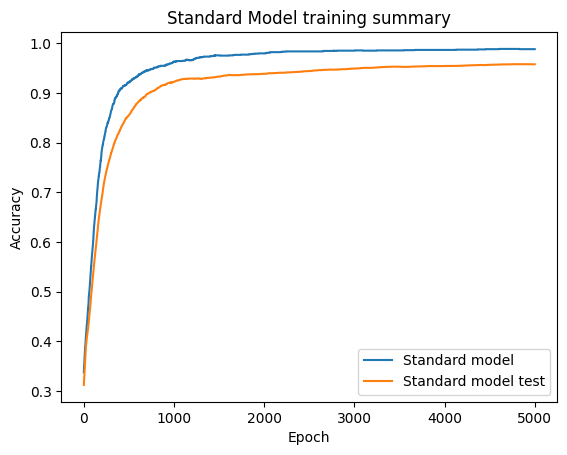

Training spanning tree model...
0 1.1005994081497192 0.352 0.34275
100 1.0707684755325317 0.426 0.396
200 1.0365166664123535 0.4925 0.43025
300 0.999727725982666 0.526 0.43775
400 0.9707268476486206 0.529 0.438125
500 0.9513775110244751 0.5465 0.43425
600 0.9379184246063232 0.554 0.4315
700 0.9275482892990112 0.5585 0.430625
800 0.9183434844017029 0.57 0.426125
900 0.9088467359542847 0.587 0.425625
1000 0.8975813388824463 0.596 0.424875
1100 0.8861430883407593 0.6105 0.427875
1200 0.8755252957344055 0.6195 0.427375
1300 0.8642715215682983 0.6215 0.423375
1400 0.8517817258834839 0.625 0.419
1500 0.8391362428665161 0.63 0.418125
1600 0.8275161385536194 0.639 0.412125
1700 0.8171029686927795 0.6515 0.41025
1800 0.807691216468811 0.659 0.404875
1900 0.7996607422828674 0.6645 0.40325
2000 0.792564868927002 0.666 0.402125
2100 0.7860421538352966 0.6745 0.404
2200 0.7804263830184937 0.674 0.40575
2300 0.7751742005348206 0.679 0.401875
2400 0.7703841328620911 0.6815 0.401625
2500 0.76668238639

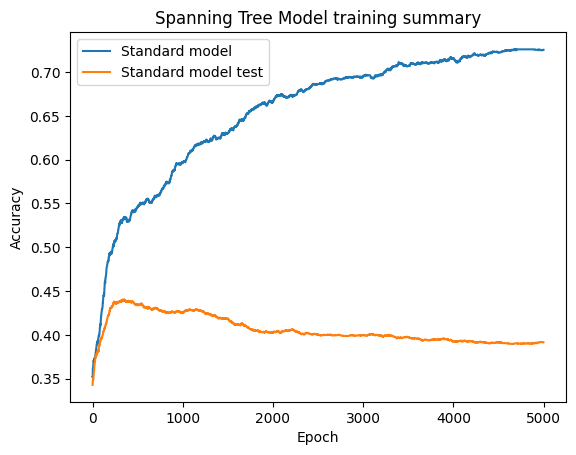

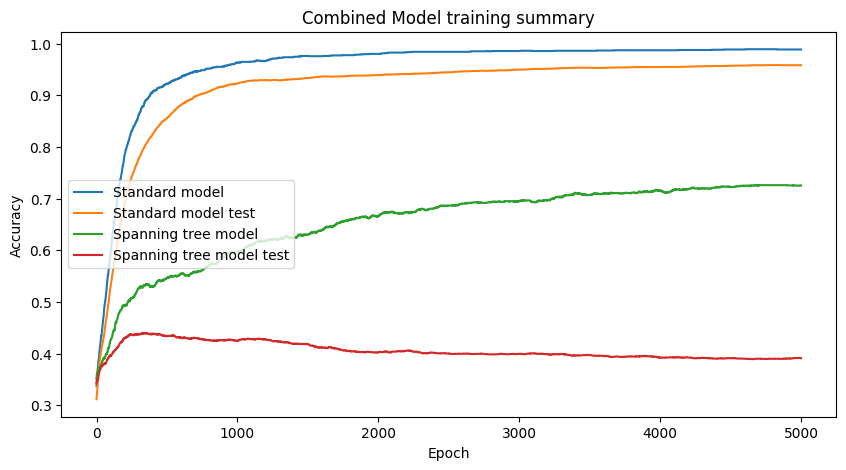

In [ ]:
r8 = syntheticManager.trainModels(
  params = {
    "learning_rate": 1e-3,
    "num_epochs": 5000,
    "weight_decay": 0.001
  }, print_rate = 100
)

In [14]:
# Just the results that need better graphs.

Training standard model...
0 2.5799598693847656 0.2571428571428571 0.21
100 1.0283138751983643 0.6857142857142857 0.493
200 0.7043329477310181 0.8357142857142857 0.567
300 0.5206179022789001 0.9071428571428571 0.612
400 0.3849165439605713 0.9 0.614
500 0.18723928928375244 0.9857142857142858 0.658
600 0.1470063477754593 0.9857142857142858 0.676
700 0.12685170769691467 0.9928571428571429 0.685
800 0.12048933655023575 0.9928571428571429 0.694
900 0.11644677072763443 0.9928571428571429 0.687
1000 0.11602935940027237 0.9928571428571429 0.688
1100 0.11577291786670685 1.0 0.689
1200 0.1166064664721489 1.0 0.693
1300 0.11700151860713959 1.0 0.691
1400 0.11787526309490204 1.0 0.695
1500 0.11903814226388931 1.0 0.691
1600 0.12038441002368927 1.0 0.687
1700 0.12122920900583267 1.0 0.692
1800 0.12118745595216751 1.0 0.693
1900 0.12166284769773483 1.0 0.698
2000 0.12085926532745361 1.0 0.696
2100 0.11914116889238358 1.0 0.7
2200 0.11680205166339874 1.0 0.707
2300 0.11525208503007889 1.0 0.709
2400 

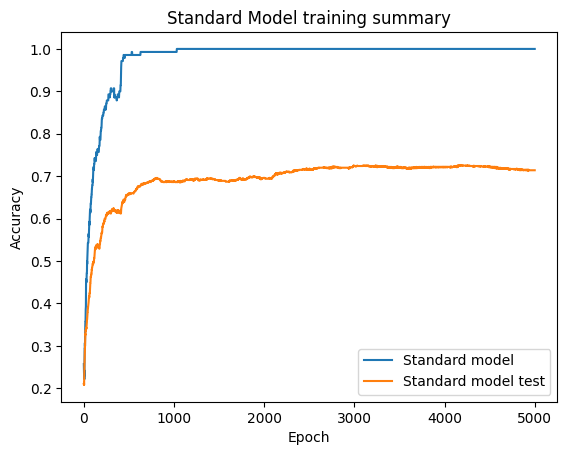

Training spanning tree model...
0 4.0376811027526855 0.18571428571428572 0.235
100 1.424716591835022 0.5642857142857143 0.357
200 1.1747552156448364 0.7428571428571429 0.393
300 0.9975747466087341 0.8428571428571429 0.426
400 0.7761305570602417 0.9 0.471
500 0.6032480001449585 0.9285714285714286 0.552
600 0.4732200503349304 0.9571428571428572 0.552
700 0.3850283622741699 0.9714285714285714 0.562
800 0.32553350925445557 0.9785714285714285 0.558
900 0.2890269458293915 0.9857142857142858 0.575
1000 0.2708001136779785 0.9857142857142858 0.584
1100 0.2612859308719635 0.9857142857142858 0.594
1200 0.2571834623813629 0.9857142857142858 0.605
1300 0.25514671206474304 0.9857142857142858 0.609
1400 0.25423669815063477 0.9857142857142858 0.61
1500 0.25324490666389465 0.9857142857142858 0.606
1600 0.25229644775390625 0.9857142857142858 0.606
1700 0.25210854411125183 0.9857142857142858 0.607
1800 0.2521480619907379 0.9857142857142858 0.613
1900 0.25223520398139954 0.9857142857142858 0.616
2000 0.25

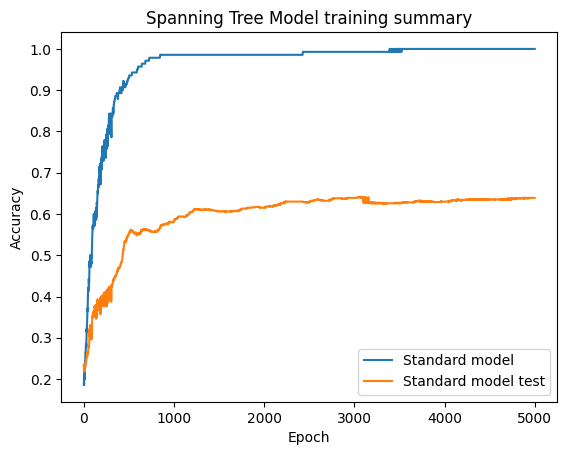

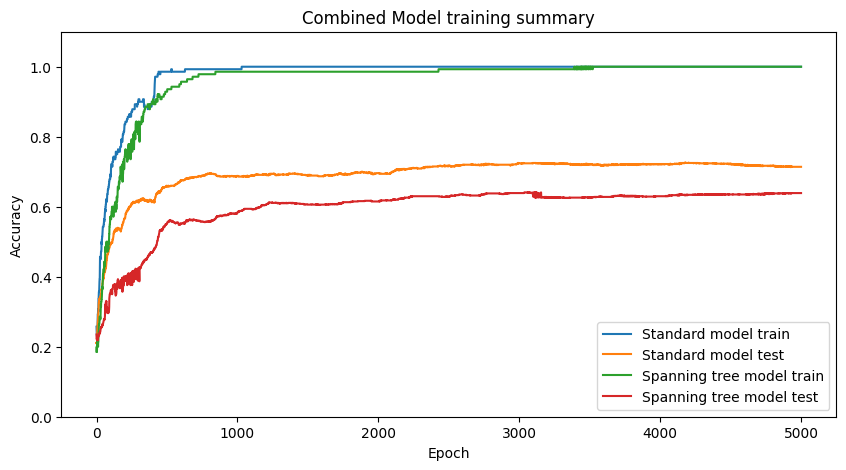

In [40]:
i1 = cora3DNarrowManager.trainModels(
  params={
    'learning_rate': 2e-4,
    'num_epochs': 5000,
    'weight_decay': 0.1,
  },
  loss_fn=nn.CrossEntropyLoss(),
  print_rate=100
)

Training standard model...
0 3.932450771331787 0.16666666666666666 0.167
1000 0.4234437346458435 0.9416666666666667 0.413
2000 0.18557460606098175 0.9583333333333334 0.548
3000 0.14632214605808258 0.975 0.596
4000 0.1035655215382576 1.0 0.601


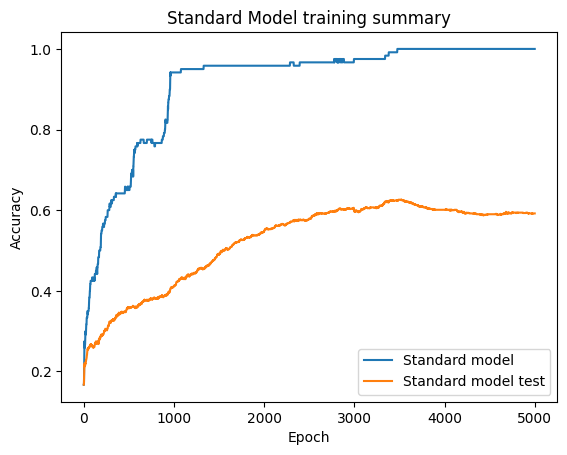

Training spanning tree model...
0 1.8386666774749756 0.2 0.205
1000 0.35545614361763 1.0 0.508
2000 0.2302386611700058 1.0 0.544
3000 0.20320677757263184 1.0 0.563
4000 0.1887330859899521 1.0 0.557


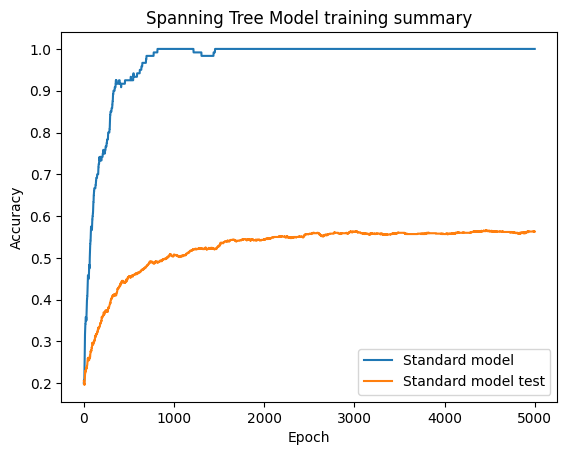

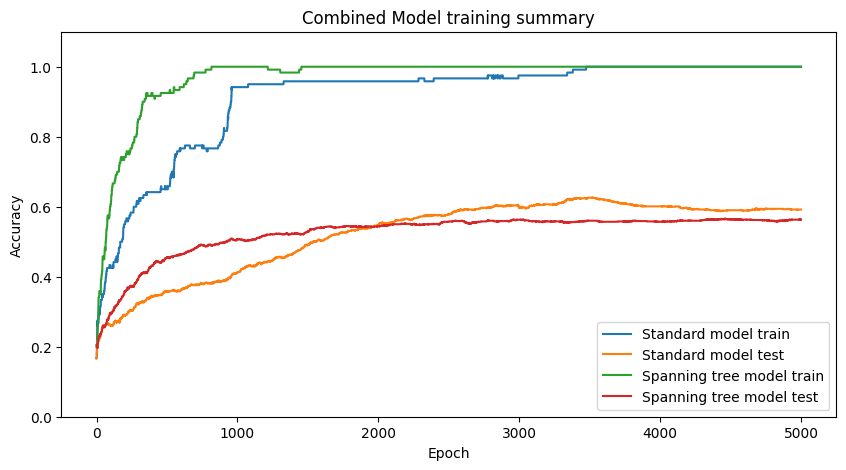

In [41]:
i2 = citeseer3dNarrowManager.trainModels(
  params={
    'learning_rate': 1e-4,
    'num_epochs': 5000,
    'weight_decay': 0.1,
  },
  loss_fn=nn.CrossEntropyLoss(),
  print_rate=1000
)

Training standard model...
0 1.2647125720977783 0.2765 0.32175
1000 0.2148168385028839 0.9385 0.913375
2000 0.12654347717761993 0.9745 0.939125
3000 0.10066166520118713 0.983 0.945625
4000 0.08925419300794601 0.986 0.953


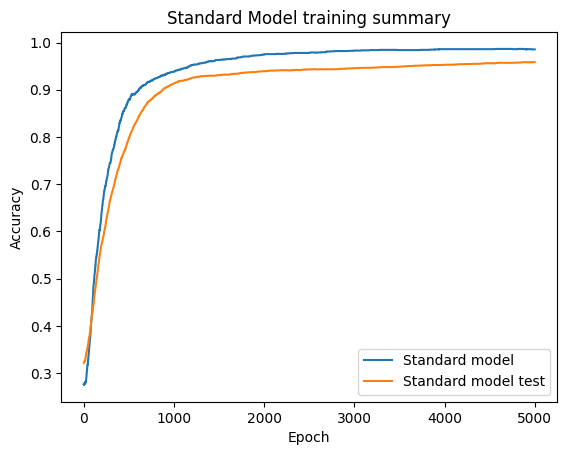

Training spanning tree model...
0 1.1059541702270508 0.304 0.325625
1000 0.8841000199317932 0.6 0.404875
2000 0.795883059501648 0.6745 0.390125
3000 0.7597649097442627 0.691 0.385875
4000 0.7443864345550537 0.7035 0.385625


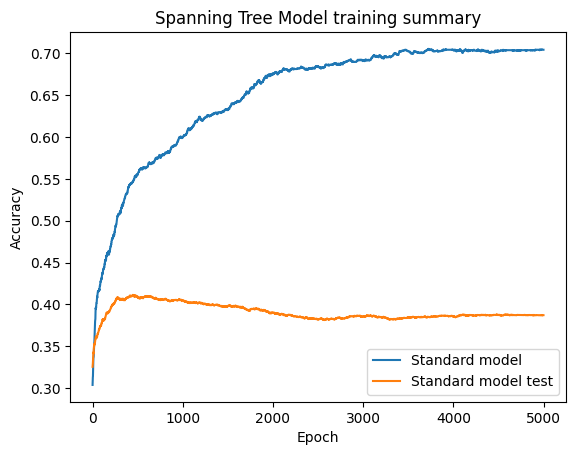

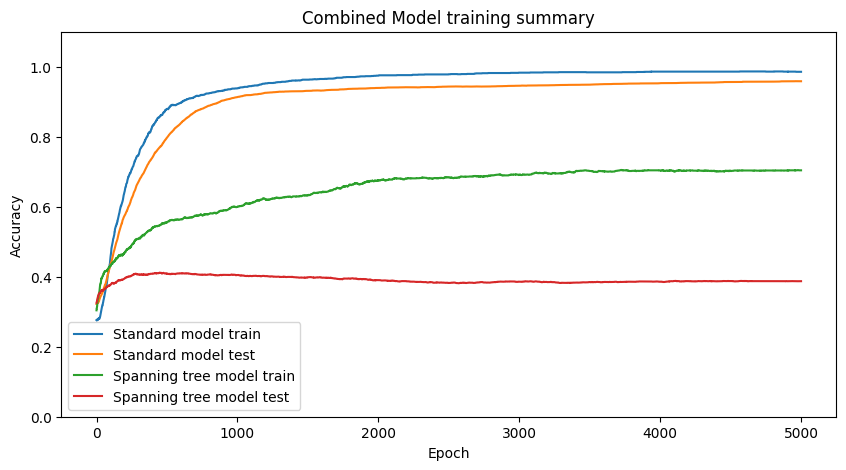

In [42]:
i3 = syntheticManager.trainModels(
  params = {
    "learning_rate": 1e-3,
    "num_epochs": 5000,
    "weight_decay": 0.001
  }, print_rate = 1000
)